In [1]:
#Подключение библиотек

#Для работы с данными
import numpy as np
import pandas as pd

#Для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

#Для машинного обучения
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

#Прочее
from collections import Counter
from datetime import datetime
import time

#Графики в оформлении seaborn
sns.set()

#Для воспроизведения результатов
RANDOM_SEED = 42

# 1. Загрузка данных

In [2]:
#Локальный путь на Kaggle
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
#Загрузка данных
df_train = pd.read_csv(DATA_DIR + '/main_task.csv')
df_test = pd.read_csv(DATA_DIR + '/kaggle_task.csv')

In [3]:
#Метим тестовые/тренировочные данные
df_test['Rating'] = 0
df_test['Kaggle'] = 1
df_train['Kaggle'] = 0
#Объединение
df = pd.concat([df_test, df_train],sort=False)

In [4]:
#Копирование для конечного сравнения
df_init = df.copy()

# 2. Предварительная обработка данных

In [5]:
#Количество прецендентов
df.shape

(50000, 11)

In [6]:
#Осмотр данных
df.head()

Restaurant_id        City  \
0          id_0       Paris   
1          id_1    Helsinki   
2          id_2   Edinburgh   
3          id_3      London   
4          id_4  Bratislava   

                                       Cuisine Style  Ranking Price Range  \
0                                     ['Bar', 'Pub']  12963.0    $$ - $$$   
1  ['European', 'Scandinavian', 'Gluten Free Opti...    106.0    $$ - $$$   
2                            ['Vegetarian Friendly']    810.0    $$ - $$$   
3  ['Italian', 'Mediterranean', 'European', 'Vege...   1669.0        $$$$   
4  ['Italian', 'Mediterranean', 'European', 'Seaf...     37.0        $$$$   

   Number of Reviews                                            Reviews  \
0                4.0                                           [[], []]   
1               97.0  [['Very good reviews!', 'Fine dining in Hakani...   
2               28.0  [['Better than the Links', 'Ivy Black'], ['12/...   
3              202.0  [['Most exquisite', 'Delicious and authentic']...   
4              162.0  [['Always the best in bratislava', 'Very good ...   

                                              URL_TA      ID_TA  Rating  \
0  /Restaurant_Review-g187147-d10746918-Reviews-L...  d10746918     0.0   
1  /Restaurant_Review-g189934-d6674944-Reviews-Ra...   d6674944     0.0   
2  /Restaurant_Review-g186525-d13129638-Reviews-B...  d13129638     0.0   
3  /Restaurant_Review-g186338-d680417-Reviews-Qui...    d680417     0.0   
4  /Restaurant_Review-g274924-d1112354-Reviews-Ma...   d1112354     0.0   

   Kaggle  
0       1  
1       1  
2       1  
3       1  
4       1

In [7]:
#Типы столбцов
df.dtypes

Restaurant_id         object
City                  object
Cuisine Style         object
Ranking              float64
Price Range           object
Number of Reviews    float64
Reviews               object
URL_TA                object
ID_TA                 object
Rating               float64
Kaggle                 int64
dtype: object

In [8]:
#Количество пропущенных значений в каждом столбце
df.isnull().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
Rating                   0
Kaggle                   0
dtype: int64

# 3. Feature engineering

## 3.1) ID_TA

In [9]:
#Осмотр данных
df_train['ID_TA'].value_counts()

d7337366     2
d7342803     2
d7809594     2
d11698990    2
d3685055     2
            ..
d4356083     1
d7345568     1
d13055068    1
d2699861     1
d7940010     1
Name: ID_TA, Length: 39980, dtype: int64

***Есть повторяющиеся ID_TA, посмотрим одинаковы ли у них параметры.***

In [10]:
#Выделяем неправильные преценденты
bugs = df_train['ID_TA'].value_counts()
index_bugs = bugs[bugs > 1].index

In [11]:
#Проверяем
for ind in index_bugs:
    df_sub = df[df['ID_TA'] == ind]
    for col in df_sub.columns:
        if df_sub.iloc[0][col] != df_sub.iloc[1][col]:
            print(col)
            print(df_sub.iloc[0][col], df_sub.iloc[1][col])
            print()

Restaurant_id
id_1225 id_1197

Ranking
1227.0 1198.0

Restaurant_id
id_2359 id_2467

Ranking
2361.0 2469.0

Restaurant_id
id_3967 id_4331

Ranking
3969.0 4333.0

Price Range
nan nan

Restaurant_id
id_3238 id_3240

Cuisine Style
nan nan

Ranking
3240.0 3242.0

Price Range
nan nan

Restaurant_id
id_5646 id_5617

Ranking
5649.0 5620.0

Restaurant_id
id_3536 id_3662

Ranking
3538.0 3664.0

Restaurant_id
id_2673 id_2485

Ranking
2675.0 2487.0

Restaurant_id
id_4110 id_4104

Ranking
4112.0 4106.0

Price Range
nan nan

Restaurant_id
id_2197 id_2329

Cuisine Style
nan nan

Ranking
2199.0 2331.0

Price Range
nan nan

Restaurant_id
id_2361 id_2312

Ranking
2363.0 2314.0

Restaurant_id
id_468 id_511

Ranking
469.0 512.0

Restaurant_id
id_3804 id_3810

Ranking
3806.0 3812.0

Price Range
nan nan

Restaurant_id
id_475 id_530

Ranking
476.0 531.0

Restaurant_id
id_2677 id_2486

Cuisine Style
nan nan

Ranking
2679.0 2488.0

Price Range
nan nan

Restaurant_id
id_1180 id_1209

Ranking
1181.0 1210.0

Res

***Различаются только столбцы ID и Ranking. URL-адрес совпадает, значит рестораны одинаковы. Ranking можно заменить средним или оставить так. Повторяющиеся строки также можно удалить или оставить при их малом количестве.***

In [12]:
#Осмотр данных на тесте
df_test['ID_TA'].value_counts()

d10109188    1
d6999562     1
d2712036     1
d8411341     1
d4263018     1
            ..
d11929290    1
d4769802     1
d6877299     1
d12204689    1
d4063578     1
Name: ID_TA, Length: 10000, dtype: int64

In [13]:
#Заменяем столбец
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))

***Выделим числовое значение ID_TA, может пригодиться в конечной модели.***

## 3.2) Restaurant_id

In [14]:
#Осмотр данных
df_train['Restaurant_id'].value_counts()

id_633      18
id_227      18
id_871      18
id_436      18
id_321      17
            ..
id_9820      1
id_11261     1
id_12503     1
id_13445     1
id_14490     1
Name: Restaurant_id, Length: 11909, dtype: int64

***Есть одинаковые id ресторанов. Что точно это означает - я не понял, может одна франшиза, может один владелец и так далее. Но можно это использовать в дальнейшем.***

In [15]:
#Выделение одинаковых id
ids = df_train['Restaurant_id'].value_counts()
index_ids = ids[ids > 1].index

In [16]:
#Создание нового признака - уникальный ли id
df['uniq ID'] = df['Restaurant_id'].apply(lambda x: int(x not in index_ids))

In [17]:
#Заменяем столбец
df['Restaurant_id'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))

***Выделим числовое значение Restaurant_id, может пригодиться в конечной модели.***

## 3.3) URL_TA

In [18]:
def get_url(X):
    '''
    Выделение целочисленного значения между символами g и d.
    Вход:
    * X - Строка.
    Выход:
    * Целочисленное значение.
    '''
    #Индекс символа 'g'
    first_symbol = df_init['URL_TA'].iloc[0].find('g') + 1
    #Индекс символа 'd'
    last_symbol = df_init['URL_TA'].iloc[0].find('d') - 1
    return int(X[first_symbol:last_symbol])
#Выделение неизвестного номера g***
df['URL_TA'] = df['URL_TA'].apply(get_url)

***Выделим числовое значение URL_TA, может пригодиться в конечной модели. В строке str также есть ID_TA.***

## 3.4) Price Range

In [19]:
#Осмотр данных
df['Price Range'].value_counts(dropna=False)

$$ - $$$    23041
NaN         17361
$            7816
$$$$         1782
Name: Price Range, dtype: int64

***Категориальный признак с тремя вариантами, который можно закодировать целочисленным значением. Также много пропущенных значений.***

In [20]:
#Замена категориального признака на новый - уровень цены (чем выше значение, тем выше цена)
df['Price'] = df['Price Range'].replace({'$': 1,'$$ - $$$': 2, '$$$$': 3})
#Удаляем столбец
df.drop(['Price Range'],axis=1,inplace=True)

***Для заполнения пропусков посмотрим на статистические параметры распределения Price по городам.***

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ea1a63a20>,
      dtype=object)

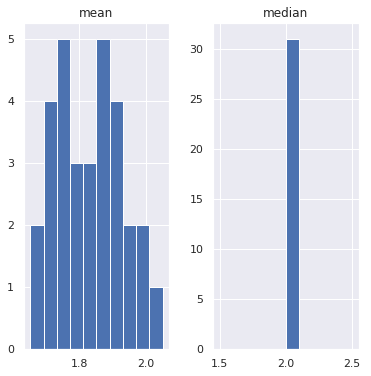

In [21]:
#Среднее по городам
df_City_price = df[~df['Price'].isna()].groupby('City')['Price'].agg(['mean','median'])
#Гистограмма
plt.rcParams['figure.figsize'] = (6,6)
df_City_price.hist()

***Все пропущенные значения можно заменить 2. Здесь и в дальнейшем пропущенные значения помечаются для прецендента отдельным признаком NaN + Name.***

In [22]:
#Метим данные с пропуском
df['NaN Price'] = df['Price'].apply(lambda x: 0 if str(x) != 'nan' else 1)

In [23]:
#Заполнение пропущенных значений
df.loc[df['Price'].isna(),'Price'] = df[df['Price'].isna()]['Price'].fillna(2)

## 3.5) Reviews

In [24]:
#Осмотр данных
df['Reviews'].iloc[1]

"[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]"

***Столбец содержит строку, которую можно перевести в список с двумя вложенными списками. Первый вложенный список содержит текст отзывов, второй - дату их публикацию.***

***Извлечем даты отзывов.***

In [25]:
def get_date_reviews(x):
    '''
    Перевод str в формат datetime (для столбца Reviews)
    Вход:
    * x - строка str.
    Выход:
    * Список из двух дат.
    '''
    #Определение индекса в строке
    ind = x.find('], [')
    #Срез
    x = x[ind+4:-2]
    #Удаление кавычек и создание списка
    mas_date_str = x.replace("'", '').split(', ')
    #Проверка пустой или нет список
    if len(mas_date_str) == 2:
        #Перевод в формат datetime
        mas_date = [datetime.strptime(d, '%m/%d/%Y') for d in mas_date_str]
    else:
        #Возвращение пустого значения
        mas_date = np.nan
    return mas_date

In [26]:
#Заполняем пропуски
df['Reviews'].fillna('[[],[]]',inplace=True)
#Создаем новый признак: список из двух дат (datetime)
df['Date Reviews'] = df['Reviews'].apply(get_date_reviews)

In [27]:
#Раскрываем список в виде двух отдельных признаков
df['First Date Review'] = df['Date Reviews'].apply(lambda x: x[0] if type(x) == list else x)
df['Second Date Review'] = df['Date Reviews'].apply(lambda x: x[1] if type(x) == list else x)
#В формате Unix-Time
df['UNIX First Date Review'] = df['First Date Review'].apply(lambda x: time.mktime(x.timetuple()) if str(x) != 'NaT' else np.nan)
df['UNIX Second Date Review'] = df['Second Date Review'].apply(lambda x: time.mktime(x.timetuple()) if str(x) != 'NaT' else np.nan)

***Посчитаем разницу между датами публикациями отзывов. Для удобства используем UNIX-time.***

In [28]:
#Создание нового признак (интервал между отзывами)
df['Interval Review'] = abs(df['UNIX Second Date Review'] - df['UNIX First Date Review'])
#Создание нового признак (интервал между последним отзывом и сегодня (09.03.2020))
today_date = time.mktime(datetime(day=9,month=3,year=2021).timetuple())
df['Last Review'] = today_date - df[['UNIX Second Date Review','UNIX First Date Review']].apply(lambda x: max(x[0],x[1]),axis=1)

***Также для формирования новых признаков используем текст отзывов. Для начала выделяем сами отзывы, склеиваем их.***

In [29]:
def get_review(x):
    '''
    Отсечение отзывов.
    Вход:
    * x - строка str.
    Выход:
    * Строку из двух отзывов.
    '''
    #Определение индекса в строке
    ind = x.find('], [')
    #Срез
    x = x[2:ind]
    #Удаление кавычек и создание списка
    mas = x.replace("'",'').replace("[",'').replace("]",'')
    return mas

In [30]:
#Создаем новый признак: строка из двух отзывов
df['List Reviews'] = df['Reviews'].apply(get_review)

***Формируем новые признаки, которые помогут определить модели тональность отзыва.***

In [31]:
#Создаем новый признак: количество слов
df['Number words in review'] = df['List Reviews'].apply(lambda x: len(x.replace('.','').replace(',','').replace('!','').replace('?','').lower().split(' ')))

In [32]:
#Создаем новый признак: количество уникальных слов
df['Unique Number words in review'] = df['List Reviews'].apply(lambda x: len(set(x.replace('.','').replace(',','').replace('!','').replace('?','').lower().split(' '))))

In [33]:
#Создаем новый признак: количество определенных знаков
df['Number 1 symbol in review'] = df['List Reviews'].apply(lambda x: x.count('!'))
df['Number 2 symbol in review'] = df['List Reviews'].apply(lambda x: x.count('?'))

***Попробуем решить задачу без привлечения стороннего датасета. Рассмотрим все возможные слова. Просмотрим большинство из них и соберем две группы слов - плохие и хорошие.***

In [34]:
#Создаем Counter для получения всех слов
Mas_Word = Counter()
#Промежуточная функция для заполнения Counter
def get_Word(X):
    X = X.replace('.','').replace(',','').replace('!','').replace('?','').lower().split(' ')
    for x in X:
        Mas_Word[x] += 1
    pass
#Заполнение Counter
df['List Reviews'].apply(get_Word)
#Создание DataFrame из Counter
df_Word = pd.DataFrame(list(Mas_Word.most_common()),columns=['Word','Number']).set_index('Word')

In [35]:
#Осмотр данных
df_Word.head(650)

Number
Word              
food         12988
good         11688
great        10544
and           9724
              9109
...            ...
m               49
fried           49
how             49
pho             48
disgusting      48

[650 rows x 1 columns]

In [36]:
#Списки из плохих или хороших слов
good_words = ['good','best','excellent','wow','fantastic','cool','five','great','nice',
              'lovely','perfect','decent','pleasant','super','yummy','fabulous',
             'outstanding','recommended','cute','enjoyable','pretty','charming',
             'happy','delightful','recommend','relaxing','convenient','enjoy','yum',
             'comfortable','delight','"best','inexpensive','exceptional','stylish',
             'cheerful','gorgeous','treasure','hospitality','elegant','perfectly',
             'space','impressed','ideal','"great','reliable']
bad_words = ['worst','bad','terrible','disappointing','bite','rude','awful','pricey',
            'horrible','mediocre','disappointed','incredible','unfriendly','trap',
            'disappointment','noisy','hit','beaten','disgusting']

In [37]:
def get_number_bad_word(X):
    '''
    Счетчик количества плохих слов в отзыве.
    Вход:
    * X - текст отзыва.
    Выход:
    * Количество плохих слов.
    '''
    #Ставим счетчик
    n = 0
    #Удаляем лишнее
    X = X.replace('.','').replace(',','').replace('!','').replace('?','').lower().split(' ')
    #Считаем
    for x in X:
        if x in bad_words:
            n += 1
    return n
def get_number_good_word(X):
    '''
    Счетчик количества плохих слов в отзыве.
    Вход:
    * X - текст отзыва.
    Выход:
    * Количество плохих слов.
    '''
    #Ставим счетчик
    n = 0
    #Удаляем лишнее
    X = X.replace('.','').replace(',','').replace('!','').replace('?','').lower().split(' ')
    #Считаем
    for x in X:
        if x in good_words:
            n += 1
    return n
#Создаем новый признак: счетчик плохих или хороших слов
df['Number good words in review'] = df['List Reviews'].apply(get_number_good_word)
df['Number bad words in review'] = df['List Reviews'].apply(get_number_bad_word)

In [38]:
#Создаем новый признак: есть ли плохие или хорошие слова
df['Have good words in review'] = df['Number good words in review'].apply(lambda x: int(x > 0))
df['Have bad words in review'] = df['Number bad words in review'].apply(lambda x: int(x > 0))

In [39]:
#Создаем новый признак: разница плохих и хороших слов
df['Number difference words'] = df['Number good words in review'] - df['Number bad words in review']
df['Have difference words'] = df['Have good words in review'] - df['Have bad words in review']

In [40]:
#Удаление старых признаков
df.drop(['Reviews', 'Date Reviews', 'Second Date Review','First Date Review',
         'First Date Review', 'Second Date Review', 'List Reviews',
         'UNIX First Date Review', 'UNIX Second Date Review',], axis=1, inplace=True)

## 3.6) City

In [41]:
#Осмотр данных
df['City'].value_counts()

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

***Не так много, но и не так мало городов. Выделим наиболее часто встречающиеся из них.***

In [42]:
#Самые частые города
Top_City = df['City'].value_counts().index[:7]

***Для создания новых признаков обратимся к глобальной сети и попробуем связать рейтинг с его географическим положением.***

In [43]:
#Словарь - столица ли город?
#Исключение Барселона, Цюрих
dict_Capital_City = {
    1: ['London','Paris','Madrid','Berlin','Rome','Prague','Lisbon','Vienna','Amsterdam','Brussels','Stockholm',
       'Budapest','Warsaw','Dublin','Copenhagen','Athens','Oslo','Helsinki','Bratislava','Luxembourg','Ljubljana',
        'Zurich', 'Barcelona'],
    0: ['Milan','Hamburg','Munich','Lyon','Edinburgh','Oporto','Krakow','Geneva']
}

In [44]:
#Словарь - население города (2021 год)
#Источник - гугл
#В миллионах человек
dict_Population_City = {
    'Paris': 2.196,
    'Stockholm': 0.975,
    'London': 8.982,
    'Berlin': 3.769,
    'Munich': 1.472,
    'Oporto': 0.214,
    'Milan': 1.352,
    'Bratislava': 0.424,
    'Vienna': 1.897,
    'Rome': 2.873,
    'Barcelona': 5.575,
    'Madrid': 6.642,
    'Dublin': 1.388,
    'Brussels': 0.174,
    'Zurich': 0.428,
    'Warsaw': 1.708,
    'Budapest': 1.752,
    'Copenhagen': 0.602,
    'Amsterdam': 0.821,
    'Lyon': 0.513,
    'Hamburg': 1.845,
    'Lisbon': 0.504,
    'Prague': 1.309,
    'Oslo': 0.681,
    'Helsinki': 0.631,
    'Edinburgh': 0.555,
    'Geneva': 0.499,
    'Ljubljana': 0.279,
    'Athens': 0.664,
    'Luxembourg': 0.613,
    'Krakow': 0.779
}

In [45]:
#Словарь - уровень заработка в городе (2021 год)
#Источник - гугл
#В миллионах человек
dict_Income_City = {
    'Paris': 3.8,
    'Stockholm': 4.1,
    'London': 2.5,
    'Berlin': 2.7,
    'Munich': 3.9,
    'Oporto': 1.2,
    'Milan': 1.9,
    'Bratislava': 0.9,
    'Vienna': 3,
    'Rome': 1.8,
    'Barcelona': 1.9,
    'Madrid': 3,
    'Dublin': 2.1,
    'Brussels': 2,
    'Zurich': 7.0,
    'Warsaw': 1.2,
    'Budapest': 0.6,
    'Copenhagen': 4.1,
    'Amsterdam': 3.7,
    'Lyon': 1.6,
    'Hamburg': 3.8,
    'Lisbon': 0.9,
    'Prague': 1.1,
    'Oslo': 1.7,
    'Helsinki': 2.5,
    'Edinburgh': 2,
    'Geneva': 5.4,
    'Ljubljana': 1.2,
    'Athens': 0.9,
    'Luxembourg': 6.2,
    'Krakow': 1.1
}

In [46]:
#Словарь - страна
dict_Country = {
    'Paris': 'France',
    'Stockholm': 'Sweden',
    'London': 'England',
    'Berlin': 'Germany',
    'Munich': 'Germany',
    'Oporto': 'Portugal',
    'Milan': 'Italy',
    'Bratislava': 'Slovakia',
    'Vienna': 'Austria',
    'Rome': 'Italy',
    'Barcelona': 'Spain',
    'Madrid': 'Spain',
    'Dublin': 'Ireland',
    'Brussels': 'Belgium',
    'Zurich': 'Switzerland',
    'Warsaw': 'Poland',
    'Budapest': 'Hungary',
    'Copenhagen': 'Denmark',
    'Amsterdam': 'Netherlands',
    'Lyon': 'France',
    'Hamburg': 'Germany',
    'Lisbon': 'Portugal',
    'Prague': 'Chech',
    'Oslo': 'Norway',
    'Helsinki': 'Finland',
    'Edinburgh': 'England',
    'Geneva': 'Switzerland',
    'Ljubljana': 'Slovenia',
    'Athens': 'Greece',
    'Luxembourg': 'Luxembourg Country',
    'Krakow': 'Poland'
}

In [47]:
#Словарь - широта
dict_Latitude = {
    'Paris': 48,
    'Stockholm': 59,
    'London': 51,
    'Berlin': 52,
    'Munich': 48,
    'Oporto': 41,
    'Milan': 42,
    'Bratislava': 48,
    'Vienna': 48,
    'Rome': 41,
    'Barcelona': 41,
    'Madrid': 40,
    'Dublin': 53,
    'Brussels': 50,
    'Zurich': 47,
    'Warsaw': 52,
    'Budapest': 47,
    'Copenhagen': 55,
    'Amsterdam': 42,
    'Lyon': 45,
    'Hamburg': 53,
    'Lisbon': 38,
    'Prague': 50,
    'Oslo': 59,
    'Helsinki': 60,
    'Edinburgh': 55,
    'Geneva': 46,
    'Ljubljana': 46,
    'Athens': 37,
    'Luxembourg': 49,
    'Krakow': 50
}

In [48]:
#Словарь - долгота
dict_Longitude = {
    'Paris': 2,
    'Stockholm': 18,
    'London': 0,
    'Berlin': 13,
    'Munich': 11,
    'Oporto': 8,
    'Milan': 9,
    'Bratislava': 17,
    'Vienna': 16,
    'Rome': 12,
    'Barcelona': 2,
    'Madrid': -3,
    'Dublin': -6,
    'Brussels': 4,
    'Zurich': 8,
    'Warsaw': 21,
    'Budapest': 19,
    'Copenhagen': 12,
    'Amsterdam': 5,
    'Lyon': 4,
    'Hamburg': 10,
    'Lisbon': 9,
    'Prague': 14,
    'Oslo': 10,
    'Helsinki': 25,
    'Edinburgh': 3,
    'Geneva': 6,
    'Ljubljana': 14,
    'Athens': 23,
    'Luxembourg': 6,
    'Krakow': 19
}

In [49]:
#Функция для поиска нового значения столицы
def change_capital(x):
    if x in dict_Capital_City[1]:
        return 1
    else:
        return 0
    pass
#Создаем новый признак: входит ли город ресторана в ТОП лучших
df['Top City'] = df['City'].apply(lambda x: int(x in Top_City))
#Создаем новый признак: страна, в которой находится ресторан
df['Country'] = df['City'].replace(dict_Country)
#Создаем новый признак: население города без учета туристов
df['Population City'] = df['City'].replace(dict_Population_City)
#Создаем новый признак: средний доход жителя города
df['Income City'] = df['City'].replace(dict_Income_City)
#Создаем новый признак: столица ли город, в которой находится ресторан?
df['City is Capital'] = df['City'].apply(lambda x: change_capital(x))
#Создаем новый признак: географическая широта города
df['Latitude City'] = df['City'].replace(dict_Latitude)
#Создаем новый признак: географическая долгота города
df['Longitude City'] = df['City'].replace(dict_Longitude)

In [50]:
#Самые частые страны
Top_Country = df['Country'].value_counts().index[:5]
#Создаем новый признак: входит ли страна ресторана в ТОП лучших
df['Top Country'] = df['Country'].apply(lambda x: int(x in Top_Country))

## 3.7) Number of Reviews

In [51]:
#Метим данные с пропуском
df['NaN Number of Reviews'] = df['Number of Reviews'].apply(lambda x: 0 if str(x) != 'nan' else 1)

***Пропущенные значения скорее всего обозначают, что отзывов еще нет.***

In [52]:
#Заполняем пропуски
df['Number of Reviews'].fillna(0,inplace=True)

## 3.8) Cuisine

***Столбец Cuisine содержит список кухонь в ресторане в виде строки str. Для начала переведем в нужный формат.***

In [53]:
#Создание list вместо str 
df['Cuisine'] = df['Cuisine Style'].apply(lambda x: x[1:-1].replace(' ','').replace("'",'').split(',') if type(x) == str else np.nan)

***Создадим новые признаки на основе полученных списков.***

In [54]:
#Создаем новый признак: количество заявленных кухонь в ресторане
df['N Cuisine'] = df['Cuisine'].apply(lambda x: len(x) if type(x) == list else np.nan)

***Все возможные кухни, которые есть в датасэте.***

In [55]:
#Создаем Counter для получения распределения ресторанов по кухням
Mas_Cuisine = Counter()
#Промежуточная функция для заполнения Counter
def get_Cuisine(X):
    '''
    Подсчет количества кухонь.
    Вход:
    * X - список кухонь.
    Выход:
    * None.
    '''
    if type(X) == list:
        for x in X:
            Mas_Cuisine[x] += 1
    pass
#Заполнение Counter
df['Cuisine'].apply(get_Cuisine)
#Создание DataFrame из Counter
df_Cuisine = pd.DataFrame(list(Mas_Cuisine.most_common()),columns=['Name','Number']).set_index('Name')
df_Cuisine.head(15)

Number
Name                      
VegetarianFriendly   14021
European             12561
Mediterranean         7820
Italian               7433
VeganOptions          5684
GlutenFreeOptions     5185
Bar                   4094
French                3970
Asian                 3786
Pizza                 3502
Spanish               3456
Pub                   3058
Cafe                  2883
FastFood              2122
British               1992

***Кухонь очень много, поэтому необходимо сократить общее количество, чтобы провести dummy-кодирование. Есть два пути: 1. Оставить только ТОП лучших, остальные перевести в Other. 2. Создать новые группы, объединяющие старые мелкие группы.***

In [56]:
#Самые популярные кухни
Cuisine_TOP = list(df_Cuisine.index)[:15]
#Создаем новый признак: принадлежит ли топу кухонь
df['Cuisine Top'] = df['Cuisine'].apply(lambda x: int(any([i in Cuisine_TOP for i in x])) if type(x) == list else x)

In [57]:
#Новые группы кухонь
dict_Cuisine = {
    'Cuisine Vegan': ['VeganOptions','VegetarianFriendly'],
    'Cuisine GlutenFree': ['GlutenFreeOptions','Healthy'],
    'Cuisine Bar': ['Bar','WineBar','Cafe','Pub','Gastropub','BrewPub'],
    'Cuisine FastFood': ['FastFood','StreetFood'],
    'Cuisine International': ['Fusion','International','Contemporary'],
    'Cuisine Japan': ['Seafood','Sushi','Japanese'],
    'Cuisine Asian': ['Asian', 'Chinese', 'MiddleEastern','Thai','Indian','Vietnamese','Korean','Pakistani',
              'Nepali','Bangladeshi','Indonesian','Persian','Caribbean','Arabic','Malaysian','Tibetan',
              'Taiwanese','Afghani','Singaporean','Mongolian','CentralAsian','Filipino','MinorityChinese',
              'Uzbek','Azerbaijani','Fujian','Yunnan','Xinjiang','Burmese','Turkish'],
    'Cuisine Mediterranean': ['Mediterranean','Greek','Lebanese','Moroccan','Israeli','Tunisian','Egyptian'],
    'Cuisine Italian': ['Italian','Pizza'],
    'Cuisine French': ['French'],
    'Cuisine Spanish': ['Spanish'],
    'Cuisine British': ['British','Irish','Scottish'],
    'Cuisine Eastern European': ['EasternEuropean','Spanish','Portuguese','Mexican','Latin','Belgian','Dutch'],
    'Cuisine Central European': ['European','CentralEuropean','American','German','Czech','Steakhouse',
                        'Barbecue','Grill','Swiss','Danish','CentralAmerican'],
    'Cuisine Western European': ['Slovenian','Croatian','Romanian','Albanian','Welsh','Polish','Scandinavian',
                         'Swedish','Balti','Norwegian','Austrian','Hungarian','Russian','Ukrainian',
                         'Georgian','Armenian','Latvian','Caucasian'],
    'Cuisine Other': ['Halal','Soups','Delicatessen','SouthAmerican','Diner','Argentinean','African','Brazilian',
              'Peruvian','Kosher','Ethiopian','Venezuelan','Jamaican','SriLankan','Australian','Cuban',
              'Hawaiian','Colombian','Cambodian','Cajun&Creole','Southwestern','Chilean','NewZealand','Canadian',
              'Ecuadorean','NativeAmerican','Polynesian','Salvadoran']
}

In [58]:
#Удаление старого признака
df.drop(['Cuisine Style'],axis=1,inplace=True)

***Перед заменой старых групп на новые, извлечем еще дополнительные признаки из столбца.***

In [59]:
#Создание нового признака - кол-во кухонь на кол-во кухонь среднее по городу & кол-во кухонь в сумме по городу
Mas_Cuisine_City = {}
#Создаем Counter для получения распределения ресторанов по кухням
for C in df['City'].unique():
    Mas_Cuisine_City[C] = Counter()
#Промежуточная функция для заполнения Counter
def get_Cuisine_City(X,C):
    '''
    Подсчет количества кухонь для каждого города.
    Вход:
    * X - список кухонь;
    * C - город в виде string.
    Выход:
    * None.
    '''
    if type(X) == list:
        for x in X:
            Mas_Cuisine_City[C][x] += 1
    pass
#Заполнение Counter
df[['City','Cuisine']].apply(lambda x: get_Cuisine_City(x[1],x[0]), axis=1)
#Осмотр данных
Mas_Cuisine_City

{'Paris': Counter({'Bar': 406,
          'Pub': 223,
          'French': 2408,
          'Cafe': 242,
          'FastFood': 145,
          'Thai': 161,
          'European': 1528,
          'VegetarianFriendly': 1298,
          'American': 170,
          'Steakhouse': 39,
          'African': 43,
          'Fusion': 85,
          'Barbecue': 34,
          'Pizza': 248,
          'Vietnamese': 159,
          'StreetFood': 44,
          'Lebanese': 91,
          'Mediterranean': 397,
          'Italian': 583,
          'Turkish': 23,
          'Greek': 30,
          'VeganOptions': 376,
          'Halal': 47,
          'Indian': 111,
          'Japanese': 329,
          'Sushi': 162,
          'Asian': 467,
          'Arabic': 5,
          'British': 7,
          'Gastropub': 113,
          'Mexican': 36,
          'Latin': 34,
          'Peruvian': 12,
          'SouthAmerican': 46,
          'International': 78,
          'Contemporary': 69,
          'Diner': 33,
          'Healthy': 

In [60]:
#Создание Dict из Counter
Dict_Cuisine_City = {'nuniq': {}, 'sum': {}, 'median': {}}
for C in Mas_Cuisine_City:
    Dict_Cuisine_City['nuniq'][C] = len(Mas_Cuisine_City[C])
    Dict_Cuisine_City['sum'][C] = sum(Mas_Cuisine_City[C].values())
    Dict_Cuisine_City['median'][C] = np.median(np.array(list(Mas_Cuisine_City[C].values())))

In [61]:
#Осмотр данных
Dict_Cuisine_City

{'nuniq': {'Paris': 102,
  'Helsinki': 71,
  'Edinburgh': 66,
  'London': 110,
  'Bratislava': 59,
  'Lisbon': 73,
  'Budapest': 74,
  'Stockholm': 77,
  'Rome': 80,
  'Milan': 83,
  'Munich': 77,
  'Hamburg': 75,
  'Prague': 82,
  'Vienna': 89,
  'Dublin': 71,
  'Barcelona': 95,
  'Brussels': 80,
  'Madrid': 93,
  'Oslo': 64,
  'Amsterdam': 85,
  'Berlin': 98,
  'Lyon': 73,
  'Athens': 63,
  'Warsaw': 74,
  'Oporto': 47,
  'Krakow': 65,
  'Copenhagen': 76,
  'Luxembourg': 59,
  'Zurich': 77,
  'Geneva': 62,
  'Ljubljana': 55},
 'sum': {'Paris': 11775,
  'Helsinki': 1146,
  'Edinburgh': 2686,
  'London': 20147,
  'Bratislava': 703,
  'Lisbon': 3976,
  'Budapest': 3145,
  'Stockholm': 2284,
  'Rome': 7952,
  'Milan': 5967,
  'Munich': 2487,
  'Hamburg': 1777,
  'Prague': 4876,
  'Vienna': 3556,
  'Dublin': 2643,
  'Barcelona': 8309,
  'Brussels': 2966,
  'Madrid': 6854,
  'Oslo': 1406,
  'Amsterdam': 4355,
  'Berlin': 5246,
  'Lyon': 1464,
  'Athens': 1879,
  'Warsaw': 2120,
  'Oporto':

In [62]:
#Создаем новый признак: число кухонь в ресторане на количество уникальных кухонь в городе
df['Cuisine per nuniq Cuisine of City'] = df[['Cuisine','City']].apply(lambda x: len(x[0]) / Dict_Cuisine_City['nuniq'][x[1]] if type(x[0]) == list else 0, axis=1)
#Создаем новый признак: число кухонь в ресторане на все кухни в городе
df['Cuisine per Sum Cuisine of City'] = df[['Cuisine','City']].apply(lambda x: len(x[0]) / Dict_Cuisine_City['sum'][x[1]] if type(x[0]) == list else 0, axis=1)
#Создаем новый признак: число кухонь в ресторане на медианное значение кухонь в городе
df['Cuisine per median Cuisine of City'] = df[['Cuisine','City']].apply(lambda x: len(x[0]) / Dict_Cuisine_City['median'][x[1]] if type(x[0]) == list else 0, axis=1)

In [63]:
#Создаем новый признак: список наиболее часто встречаемых кухонь в городе
df['Common Cuisine of City'] = df['City'].apply(lambda x: [x[0] for x in Mas_Cuisine_City[x].most_common()[:5]])

In [64]:
#Создаем новый признак: количество кухонь из наиболее часто встречаемых по городу
df['Number of Common Cuisine'] = df[['Common Cuisine of City','Cuisine']].apply(lambda X: sum([x in X[0] for x in X[1]]) if type(X[1]) == list else 0, axis=1)

In [65]:
#Функция для поиска нового значения кухни
def change_cuisine(x):
    '''
    Замена групп Cuisine на новые.
    Вход:
    * X - Старая группа Cuisine.
    Выход:
    * Новая группа Cuisine.
    '''
    for key in dict_Cuisine.keys():
        if x in dict_Cuisine[key]:
            return key
    pass
#Новый список кухонь
df['Cuisine'] = df['Cuisine'].apply(lambda x: list(set([change_cuisine(i) for i in x])) if type(x) == list else np.nan)
#Создаем новый признак: количество кухонь в ресторане после замены
df['After N Cuisine'] = df['Cuisine'].apply(lambda x: len(x) if type(x) == list else np.nan)

## 3.9) Ranking

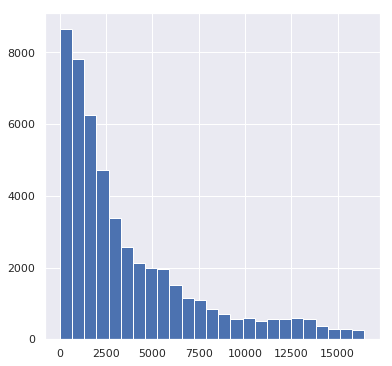

In [66]:
#Осмотр данных
df['Ranking'].hist(bins=25)

***Похоже на экспоненциальный вид. Но скорее всего дело в том, что количество кухонь по городам неравномерно. Проверим это.***

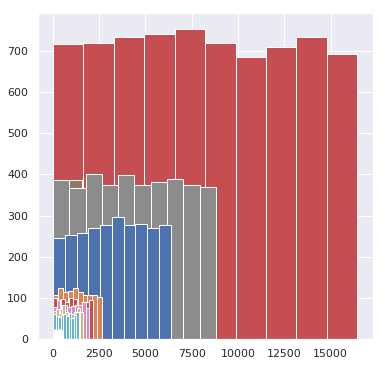

In [67]:
#Осмотр данных для разных городов
for c in df['City'].unique():
    df[df['City'] == c]['Ranking'].hist()

***Это действительно так, поэтому логично заменить данный абсолютный признак места по городу на относительный (0->1 или нормализованный).***

In [68]:
#Границы рейтинга по городам
df_City_Ranking = df.groupby('City')['Ranking'].agg(['max','min','mean','std'])
#Нормируем признак
df['Relative Ranking'] = df[['City','Ranking']].apply(lambda x: 1 - (x[1] - df_City_Ranking.loc[x[0],'min']) / (df_City_Ranking.loc[x[0],'max'] - df_City_Ranking.loc[x[0],'min']), axis=1)
df['Normalize Ranking'] = df[['City','Ranking']].apply(lambda x: (x[1] - df_City_Ranking.loc[x[0],'mean']) / df_City_Ranking.loc[x[0],'std'], axis=1)

## 3.10) New Features

In [69]:
#Создаем новый признак: максимальное число ресторанов в городе
df['Max Ranking'] = df['City'].replace(dict(df_City_Ranking['max']))
#Создаем новый признак: количество ресторанов на население в городе
df['All Restoran per Population'] = df['Max Ranking'] / df['Population City']

In [70]:
#Создаем новый признак: количество отзывов на население
df['Number of Reviews per Population'] = df['Number of Reviews'] / df['Population City']

In [71]:
#Создаем новый признак: уровень цены на уровень дохода
df['Price per Income'] = df['Price'] / df['Income City']

In [72]:
#Создаем новый признак: умножение ранга и частоты отзывов по городу
df['Relative Ranking on Number Reviews'] = df['Relative Ranking'] * df['Number of Reviews']

In [73]:
#Создаем новый признак: умножение ранга и цены
df['Relative Ranking on Price'] = df['Relative Ranking'] * df['Price per Income']

In [74]:
#DataFrame содержащий среднюю цену по городам
df_Price_city = df.groupby('City')['Price'].agg('mean')
#Создаем новый признак: средняя цена в городе
df['Mean Price of City'] = df['City'].apply(lambda x: df_Price_city[x])

In [75]:
#Создаем новый признак: Цена в ресторане к цене в городе
df['Price per Mean Price of City'] = df['Price'] / df['Mean Price of City']

In [76]:
#Медианное значение количества отзывов по городу
N_Review_City = df.groupby('City')['Number of Reviews'].agg(('median','sum'))
#Создаем новый признак: медианное число отзывов по городу
df['Number of Reviews of City'] = df['City'].apply(lambda x: N_Review_City.loc[x,'median'])
#Создаем новый признак: суммарное число отзывов по городу
df['Sum of Reviews of City'] = df['City'].apply(lambda x: N_Review_City.loc[x,'sum'])
#Создаем новый признак: число отзывов на медианное число отзывов по городу
df['Mean Number of Reviews of City'] = df['Number of Reviews'] / df['Number of Reviews of City']
#Создаем новый признак: число отзывов на суммарное число отзывов по городу
df['Number of Reviews per Sum of Reviews of City'] = df['Number of Reviews'] / df['Sum of Reviews of City']

# 4. Пост-обработка

## 4.1) Обработка NaN

In [77]:
df.isna().sum()

Restaurant_id                                       0
City                                                0
Ranking                                             0
Number of Reviews                                   0
URL_TA                                              0
ID_TA                                               0
Rating                                              0
Kaggle                                              0
uniq ID                                             0
Price                                               0
NaN Price                                           0
Interval Review                                 13794
Last Review                                     13794
Number words in review                              0
Unique Number words in review                       0
Number 1 symbol in review                           0
Number 2 symbol in review                           0
Number good words in review                         0
Number bad words in review  

### 4.1.1) Cuisine

In [78]:
#Метим данные с пропуском
df['NaN Cuisine'] = df['Cuisine'].apply(lambda x: 0 if str(x) != 'nan' else 1)

In [79]:
#Замена на новый тип
df['Cuisine'] = df['Cuisine'].fillna('Cuisine Nothing')
df['Cuisine Top'] = df['Cuisine Top'].fillna(0.25)
df['N Cuisine'] = df['N Cuisine'].fillna(1)

***В данном действии я уверен меньше всего, так как количество прецендентов с пропущенными значениями слишком велико. И как разумнее заменить мне в голову не пришло.***

### 4.1.2) Review

In [80]:
#Метим данные с пропуском
df['NaN Review'] = df['Interval Review'].apply(lambda x: 0 if str(x) != 'nan' else 1)

In [81]:
#Медианы
median_interval = df['Interval Review'].median()
median_last = df['Last Review'].median()
#Замена
df['Interval Review'] = df['Interval Review'].fillna(median_interval)
df['Last Review'] = df['Last Review'].fillna(median_last)

## 4.2) Корреляция параметров

***Проверим есть ли коррелирующие параметры.***

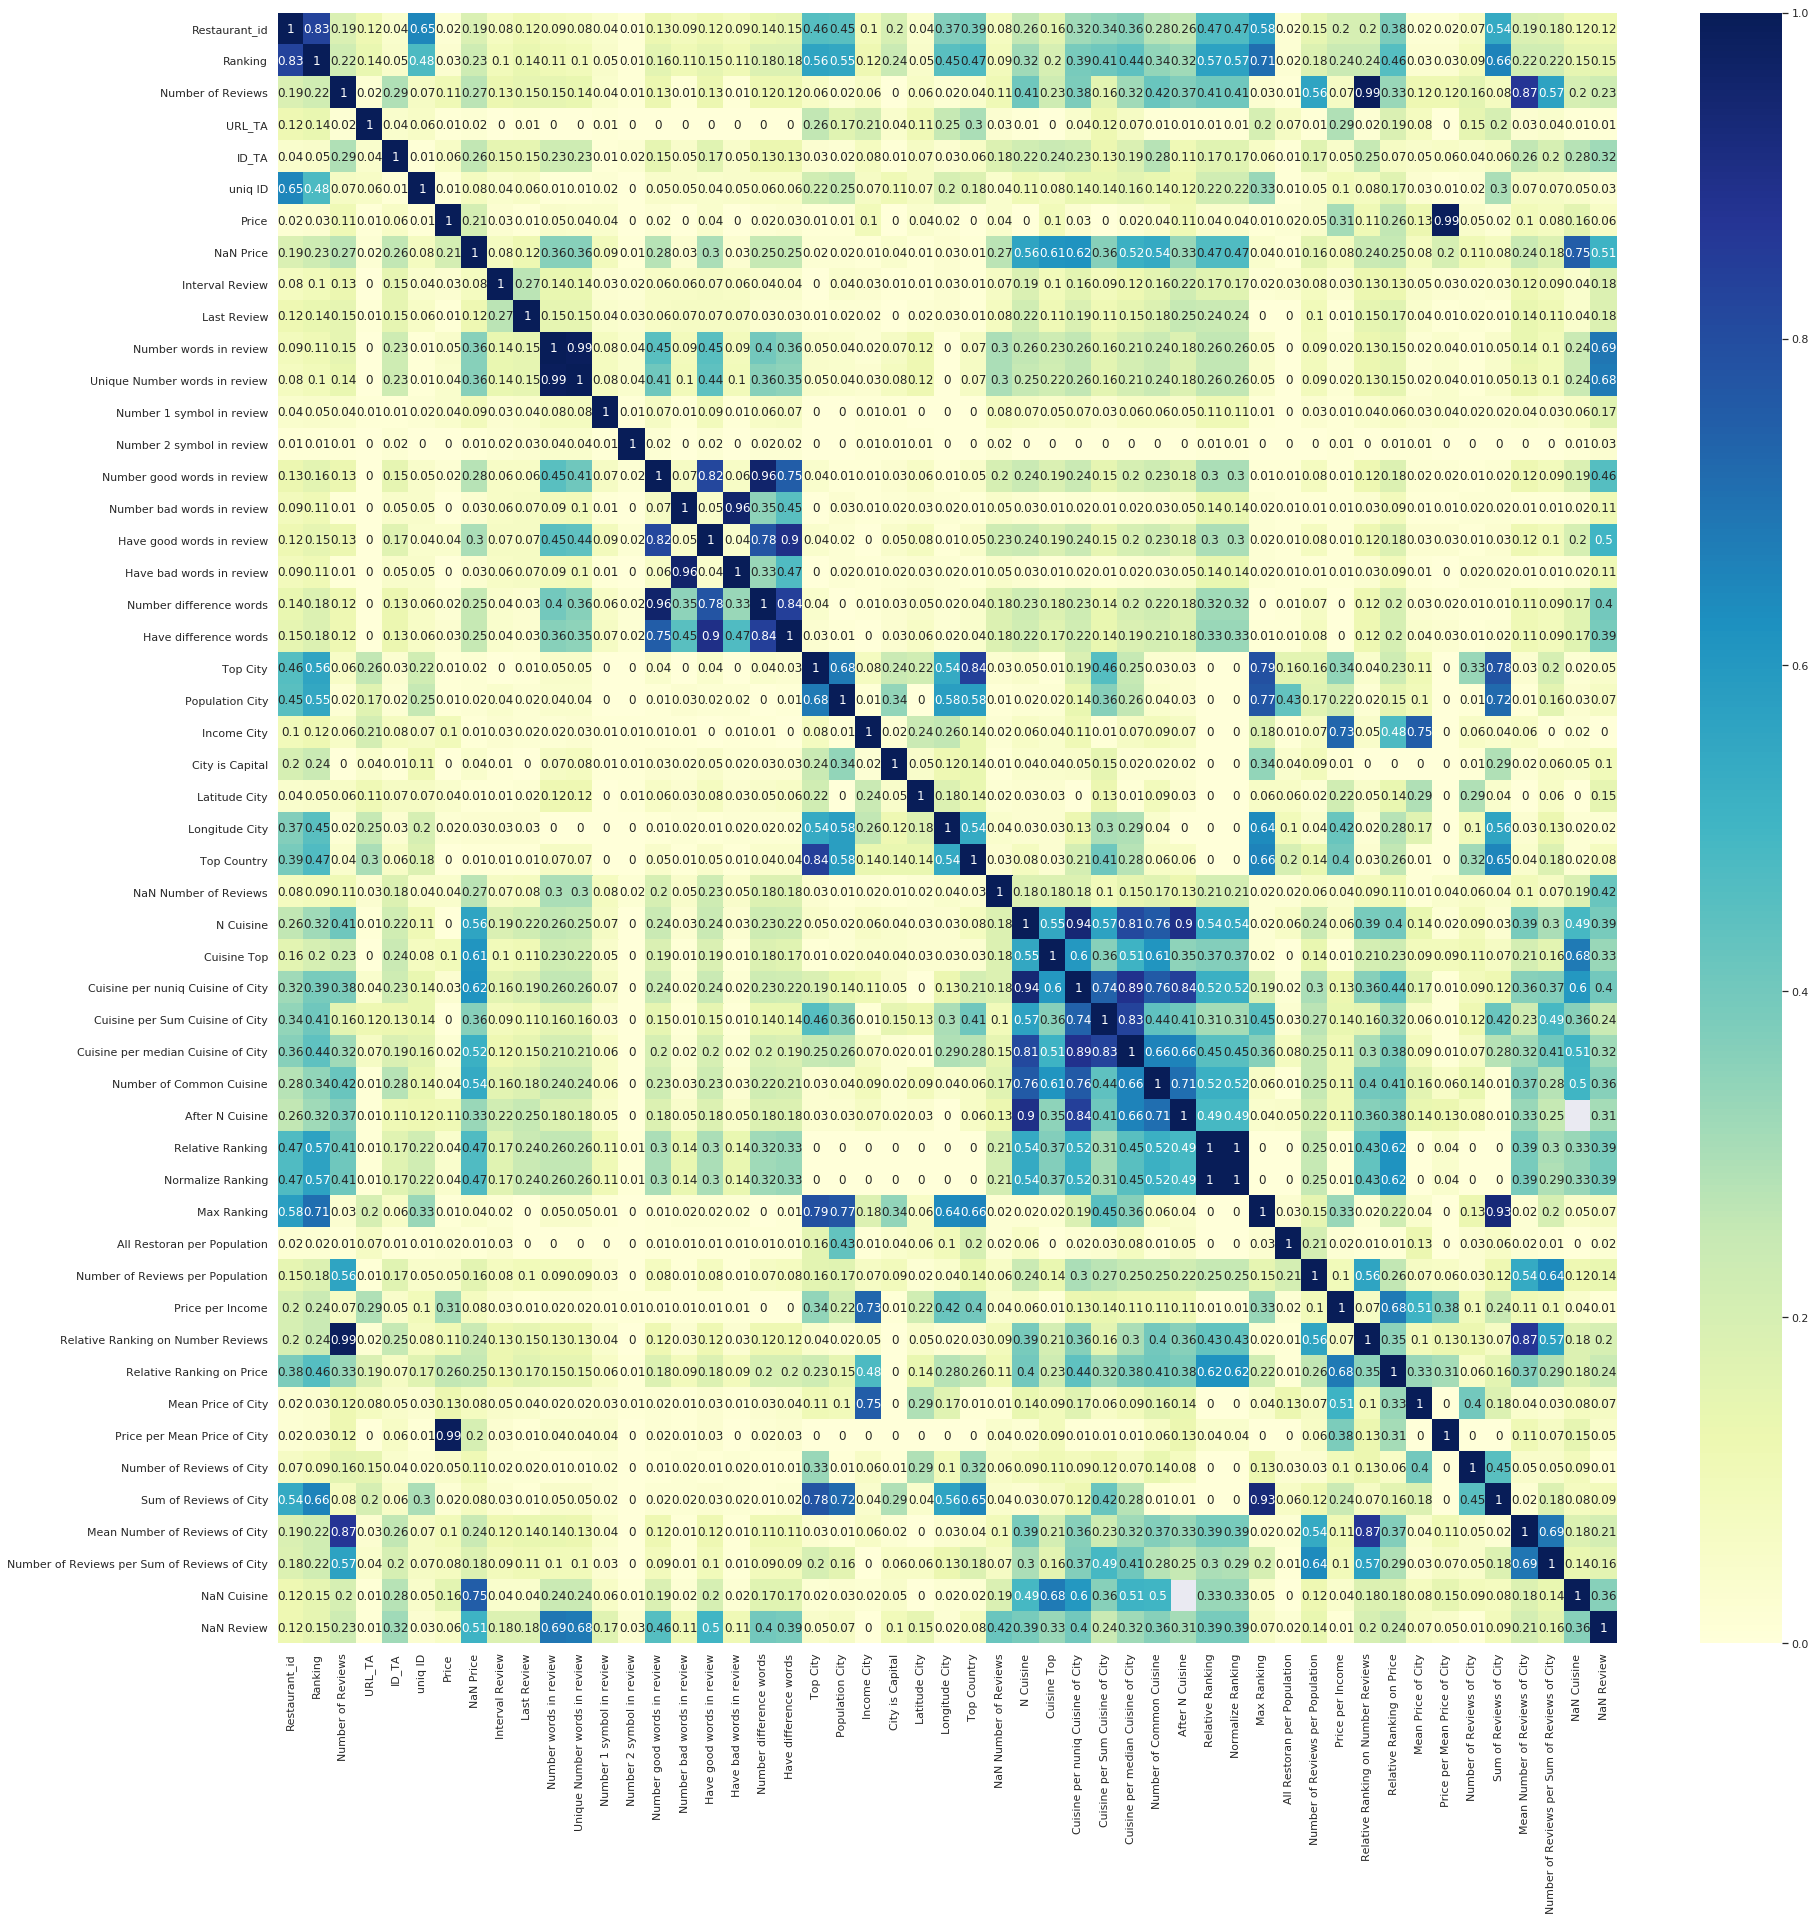

In [82]:
#Тепловая карта для матрицы корреляций
table_corr = abs(df.drop(['Rating','Kaggle'],axis=1).corr().round(2))
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(table_corr, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

***Есть значительное количество коррелирующих параметров. Устраним признаки для которых корреляция больше 0.75. Также для модели нормализуем часть признаков.***

In [83]:
#Нормализуем признаки
df_sub = df[['Number of Reviews per Population','All Restoran per Population']].agg([min,max])
df[['Relative Number of Reviews per Population','Relative All Restoran per Population']] = (df[['Number of Reviews per Population','All Restoran per Population']] - df_sub.loc['min']) / (df_sub.loc['max'] - df_sub.loc['min'])
#Удаляем признаки
df.drop(['Number of Reviews per Population','All Restoran per Population'],axis=1,inplace=True)

In [84]:
#Удаляем сильно коррелирующие признаки
df.drop([
    'Max Ranking','Number of Reviews','Restaurant_id','Price per Mean Price of City','Normalize Ranking',
    'Top City', 'Mean Number of Reviews of City','Sum of Reviews of City', 'Cuisine per median Cuisine of City', 'Cuisine per nuniq Cuisine of City', 'NaN Price','Number difference words',
    'After N Cuisine', 'Unique Number words in review','Income City','Have good words in review','Have bad words in review','Ranking'],axis=1,inplace=True)

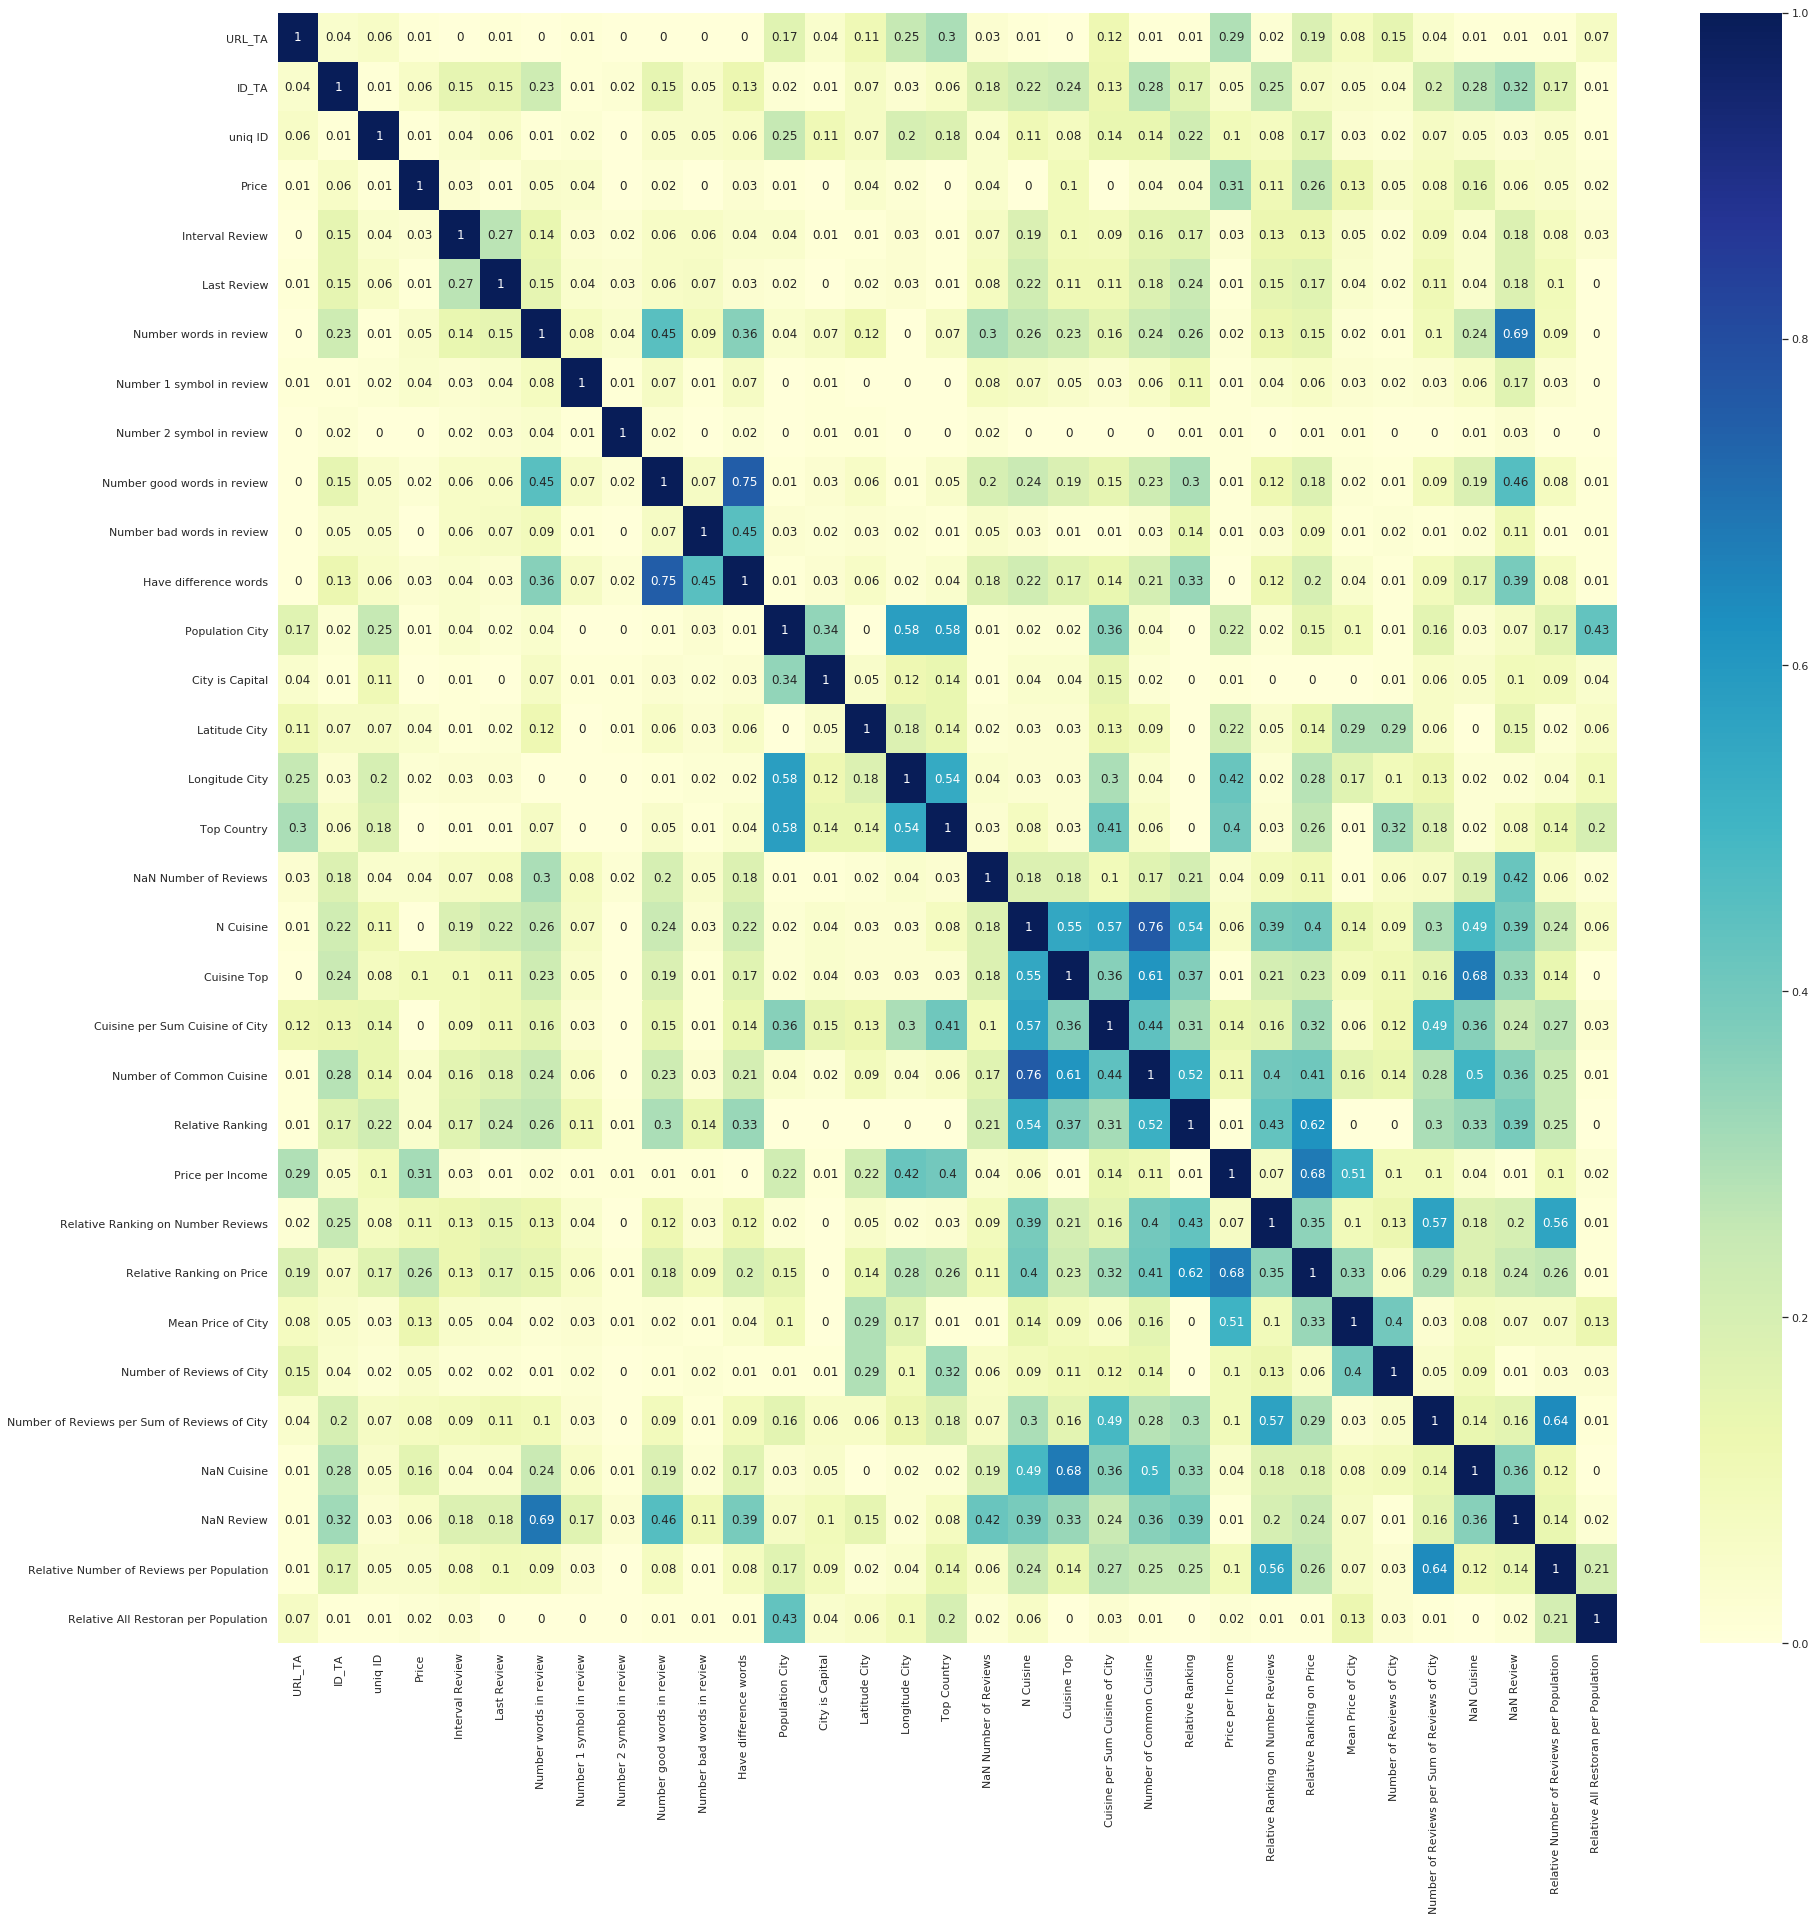

In [85]:
#Проверим
#Тепловая карта для матрицы корреляций
table_corr = abs(df.drop(['Rating','Kaggle'],axis=1).corr().round(2))
plt.rcParams['figure.figsize'] = (30,30)
sns.heatmap(table_corr, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

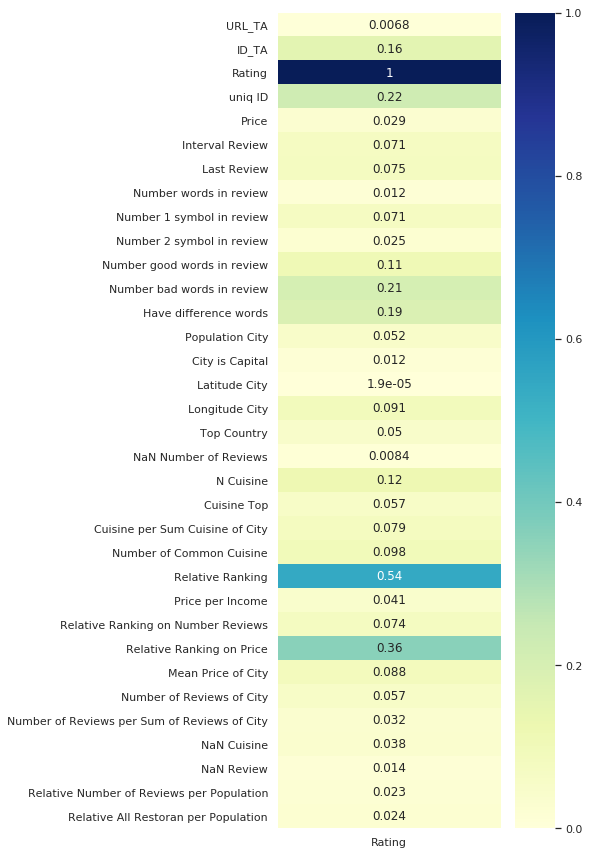

In [86]:
#Матрица корреляций для признака Rating на обучающей выборке
table_corr_rating = abs(df[df['Kaggle'] == 0].corr()['Rating'].dropna().to_frame())
plt.rcParams['figure.figsize'] = (5,15)
sns.heatmap(table_corr_rating, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

## 4.3) Dummy

***Списки кухонь и наиболее частых кухонь и название города/страны закодируем в dummy-признаки. Но по предварительным расчетом получилось, что не имеет смысла кодировать страну, так как это вызывает значительную корреляцию с признаками City. Также не имеет смысла кодировать Common Cuisine, так как это вообще не увеличило точность модели.***

### 4.3.1) Cuisine

In [87]:
#Создание нового DataFrame
df.index = np.arange(len(df))
df_new = pd.get_dummies(df['Cuisine'].apply(pd.Series).stack()).sum(level=0)

In [88]:
#Объединение
df = pd.concat([df,df_new],axis=1)

### 4.3.2) City

In [89]:
#Создание нового DataFrame
df_new = pd.get_dummies(df['City'])

In [90]:
#Объединение
df = pd.concat([df,df_new],axis=1)

### 4.3.3) Common Cuisine

In [91]:
#Создание нового DataFrame
#df.index = np.arange(len(df))
#df_new = pd.get_dummies(df['Common Cuisine of City'].apply(pd.Series).stack()).sum(level=0)

In [92]:
#Обновляем название столбцов
#df_new.columns = [('Common Cuisine ' + x) for x in df_new.columns]

In [93]:
#Объединение
#df = pd.concat([df,df_new],axis=1)

# 5. EDA

## 5.1) Снова проверим корреляцию после Dummy

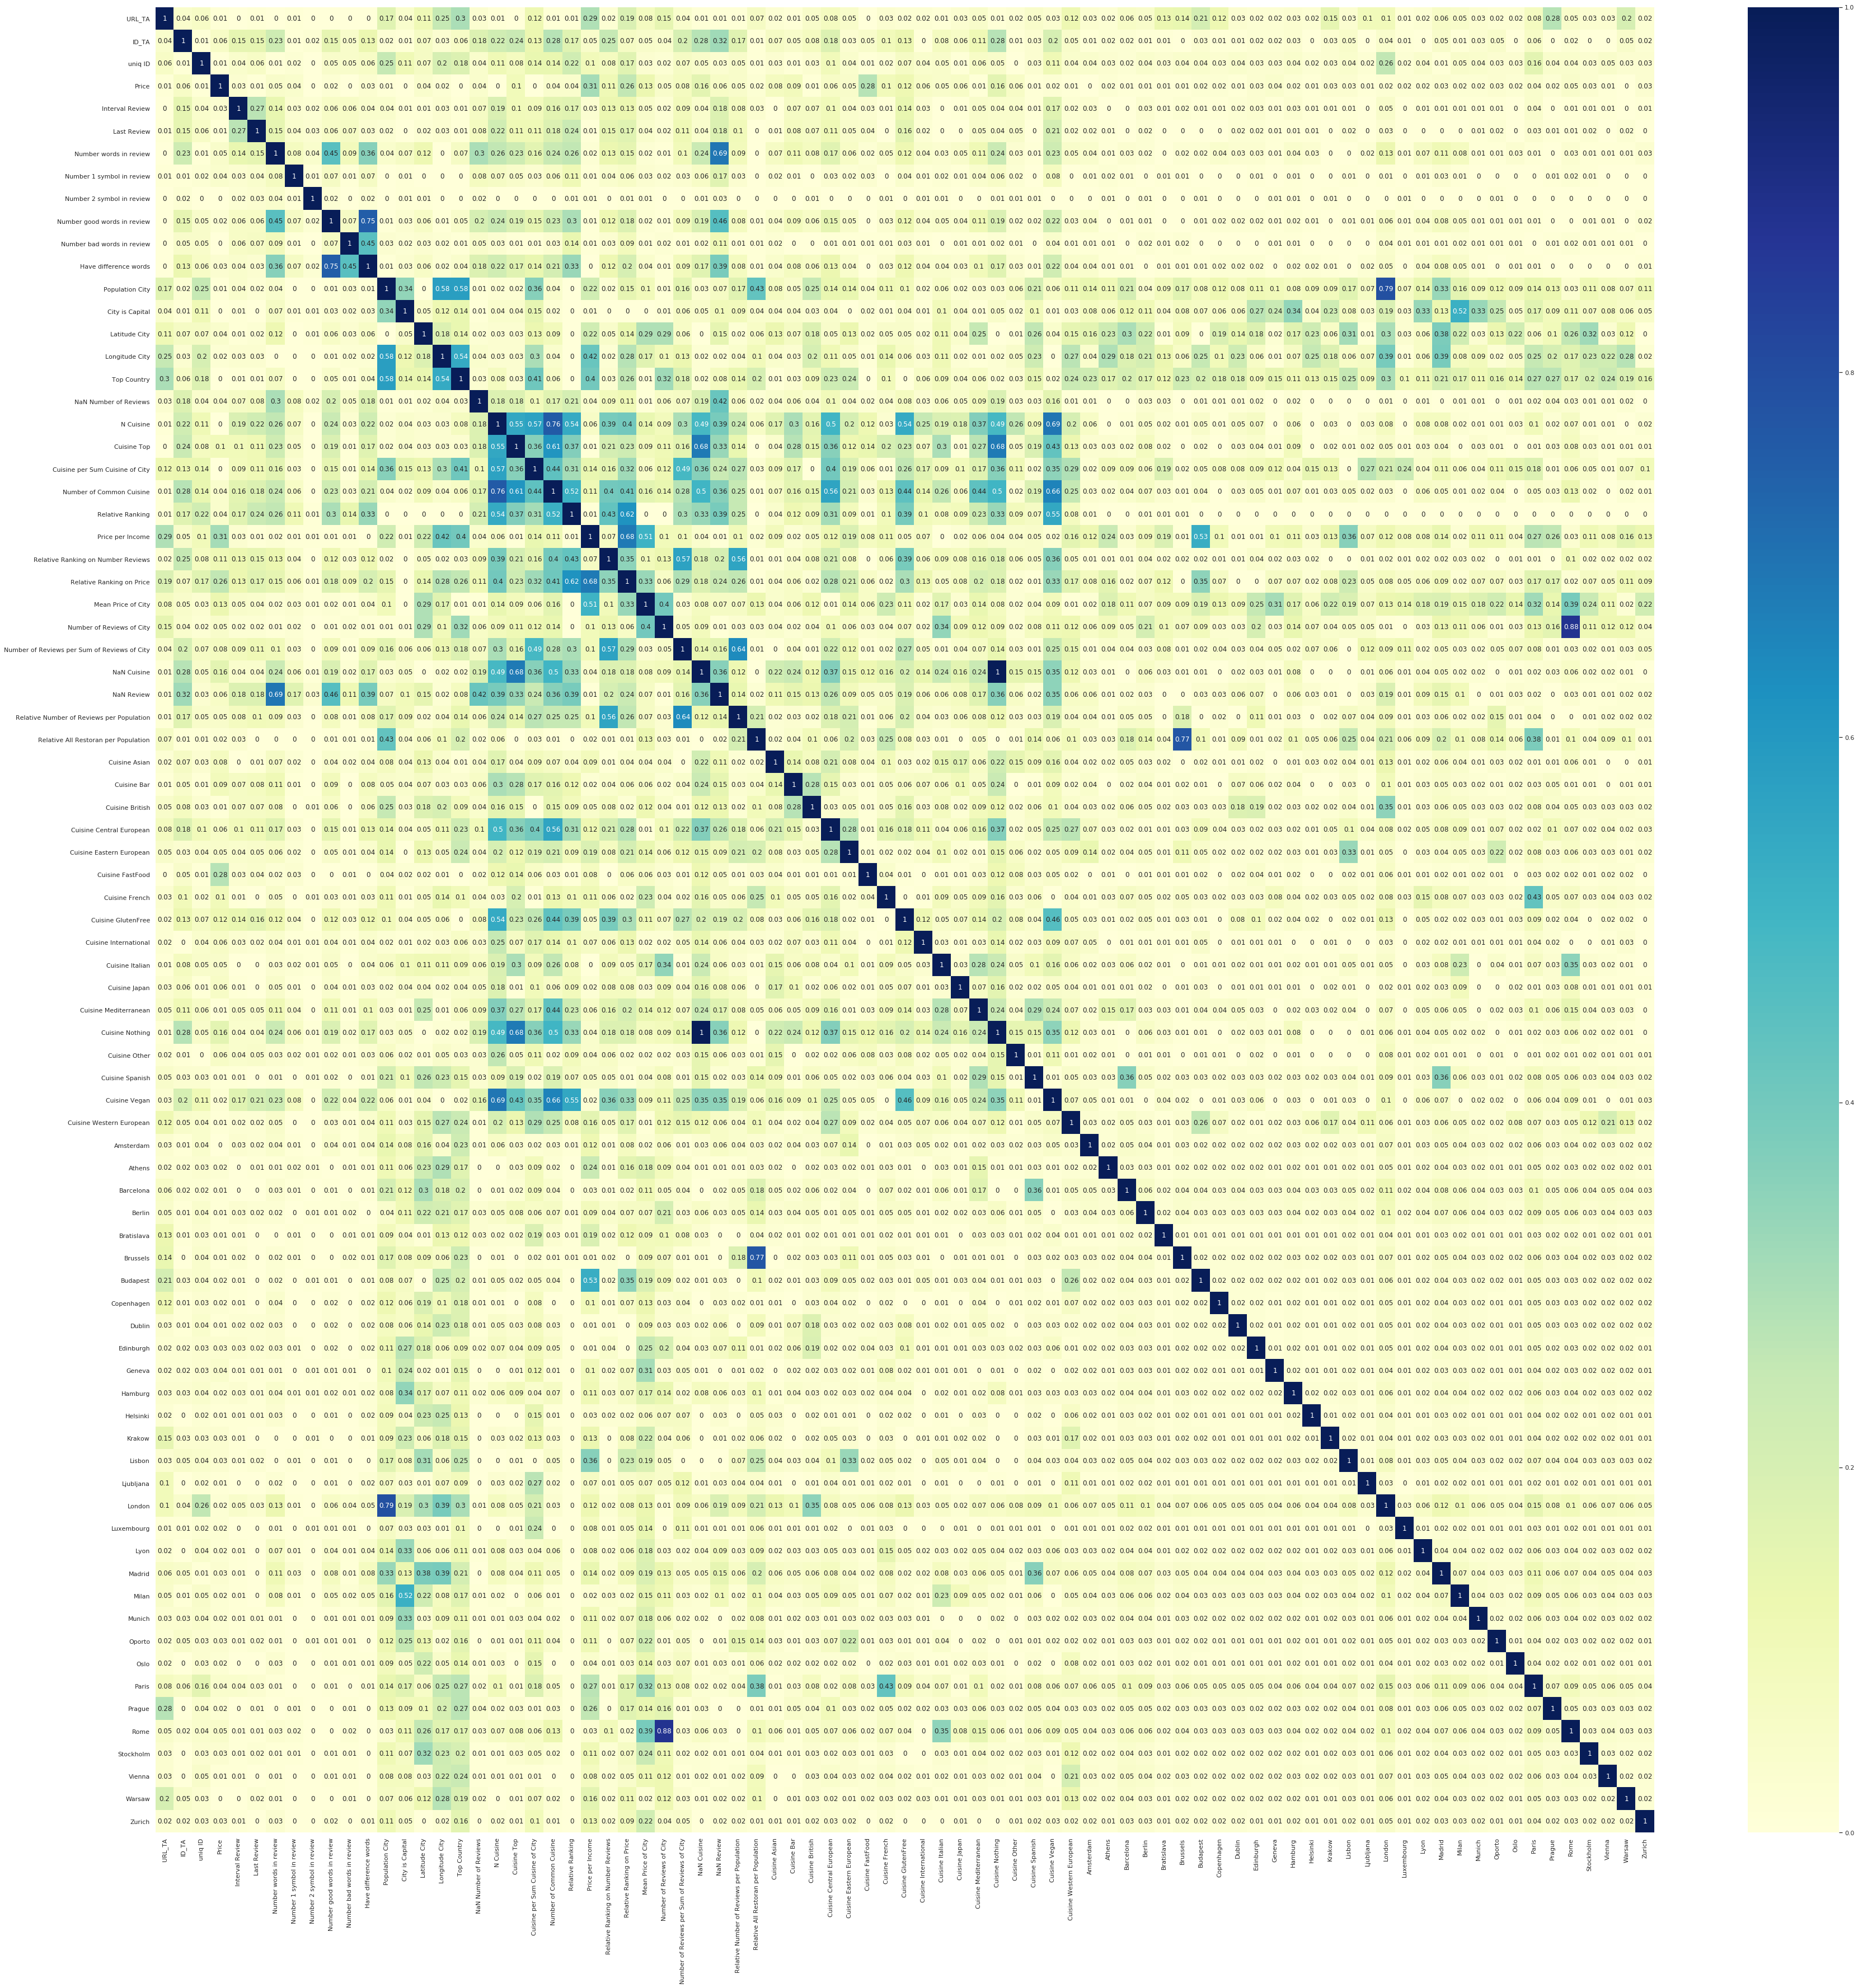

In [94]:
#Тепловая карта для матрицы корреляций
table_corr = abs(df.drop(['Rating','Kaggle'],axis=1).corr().round(2))
plt.rcParams['figure.figsize'] = (60,60)
sns.heatmap(table_corr, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

In [95]:
#После появления признака Common необходимо проверить на корреляцию
#prob = set()
#for col in table_corr.columns:
#    for ind in table_corr.index:
#        if col != ind and table_corr.loc[ind,col] == 1:
#            prob.add(ind)
#prob = list(prob)
#prob = [x for x in prob if 'Common' in x.split(' ')]

In [96]:
#Удаляем признаки
#df.drop(prob,axis=1,inplace=True)

In [97]:
#Удаляем признаки
df.drop(['London','Rome','Brussels','Cuisine Nothing'],axis=1,inplace=True)

In [98]:
#Нормализуем признаки
df_sub = df[['Interval Review','Last Review']].agg([min,max])
df[['Relative Interval Review','Relative Last Review']] = (df[['Interval Review','Last Review']] - df_sub.loc['min']) / (df_sub.loc['max'] - df_sub.loc['min'])
#Удаляем признаки
df.drop(['Interval Review','Last Review'],axis=1,inplace=True)

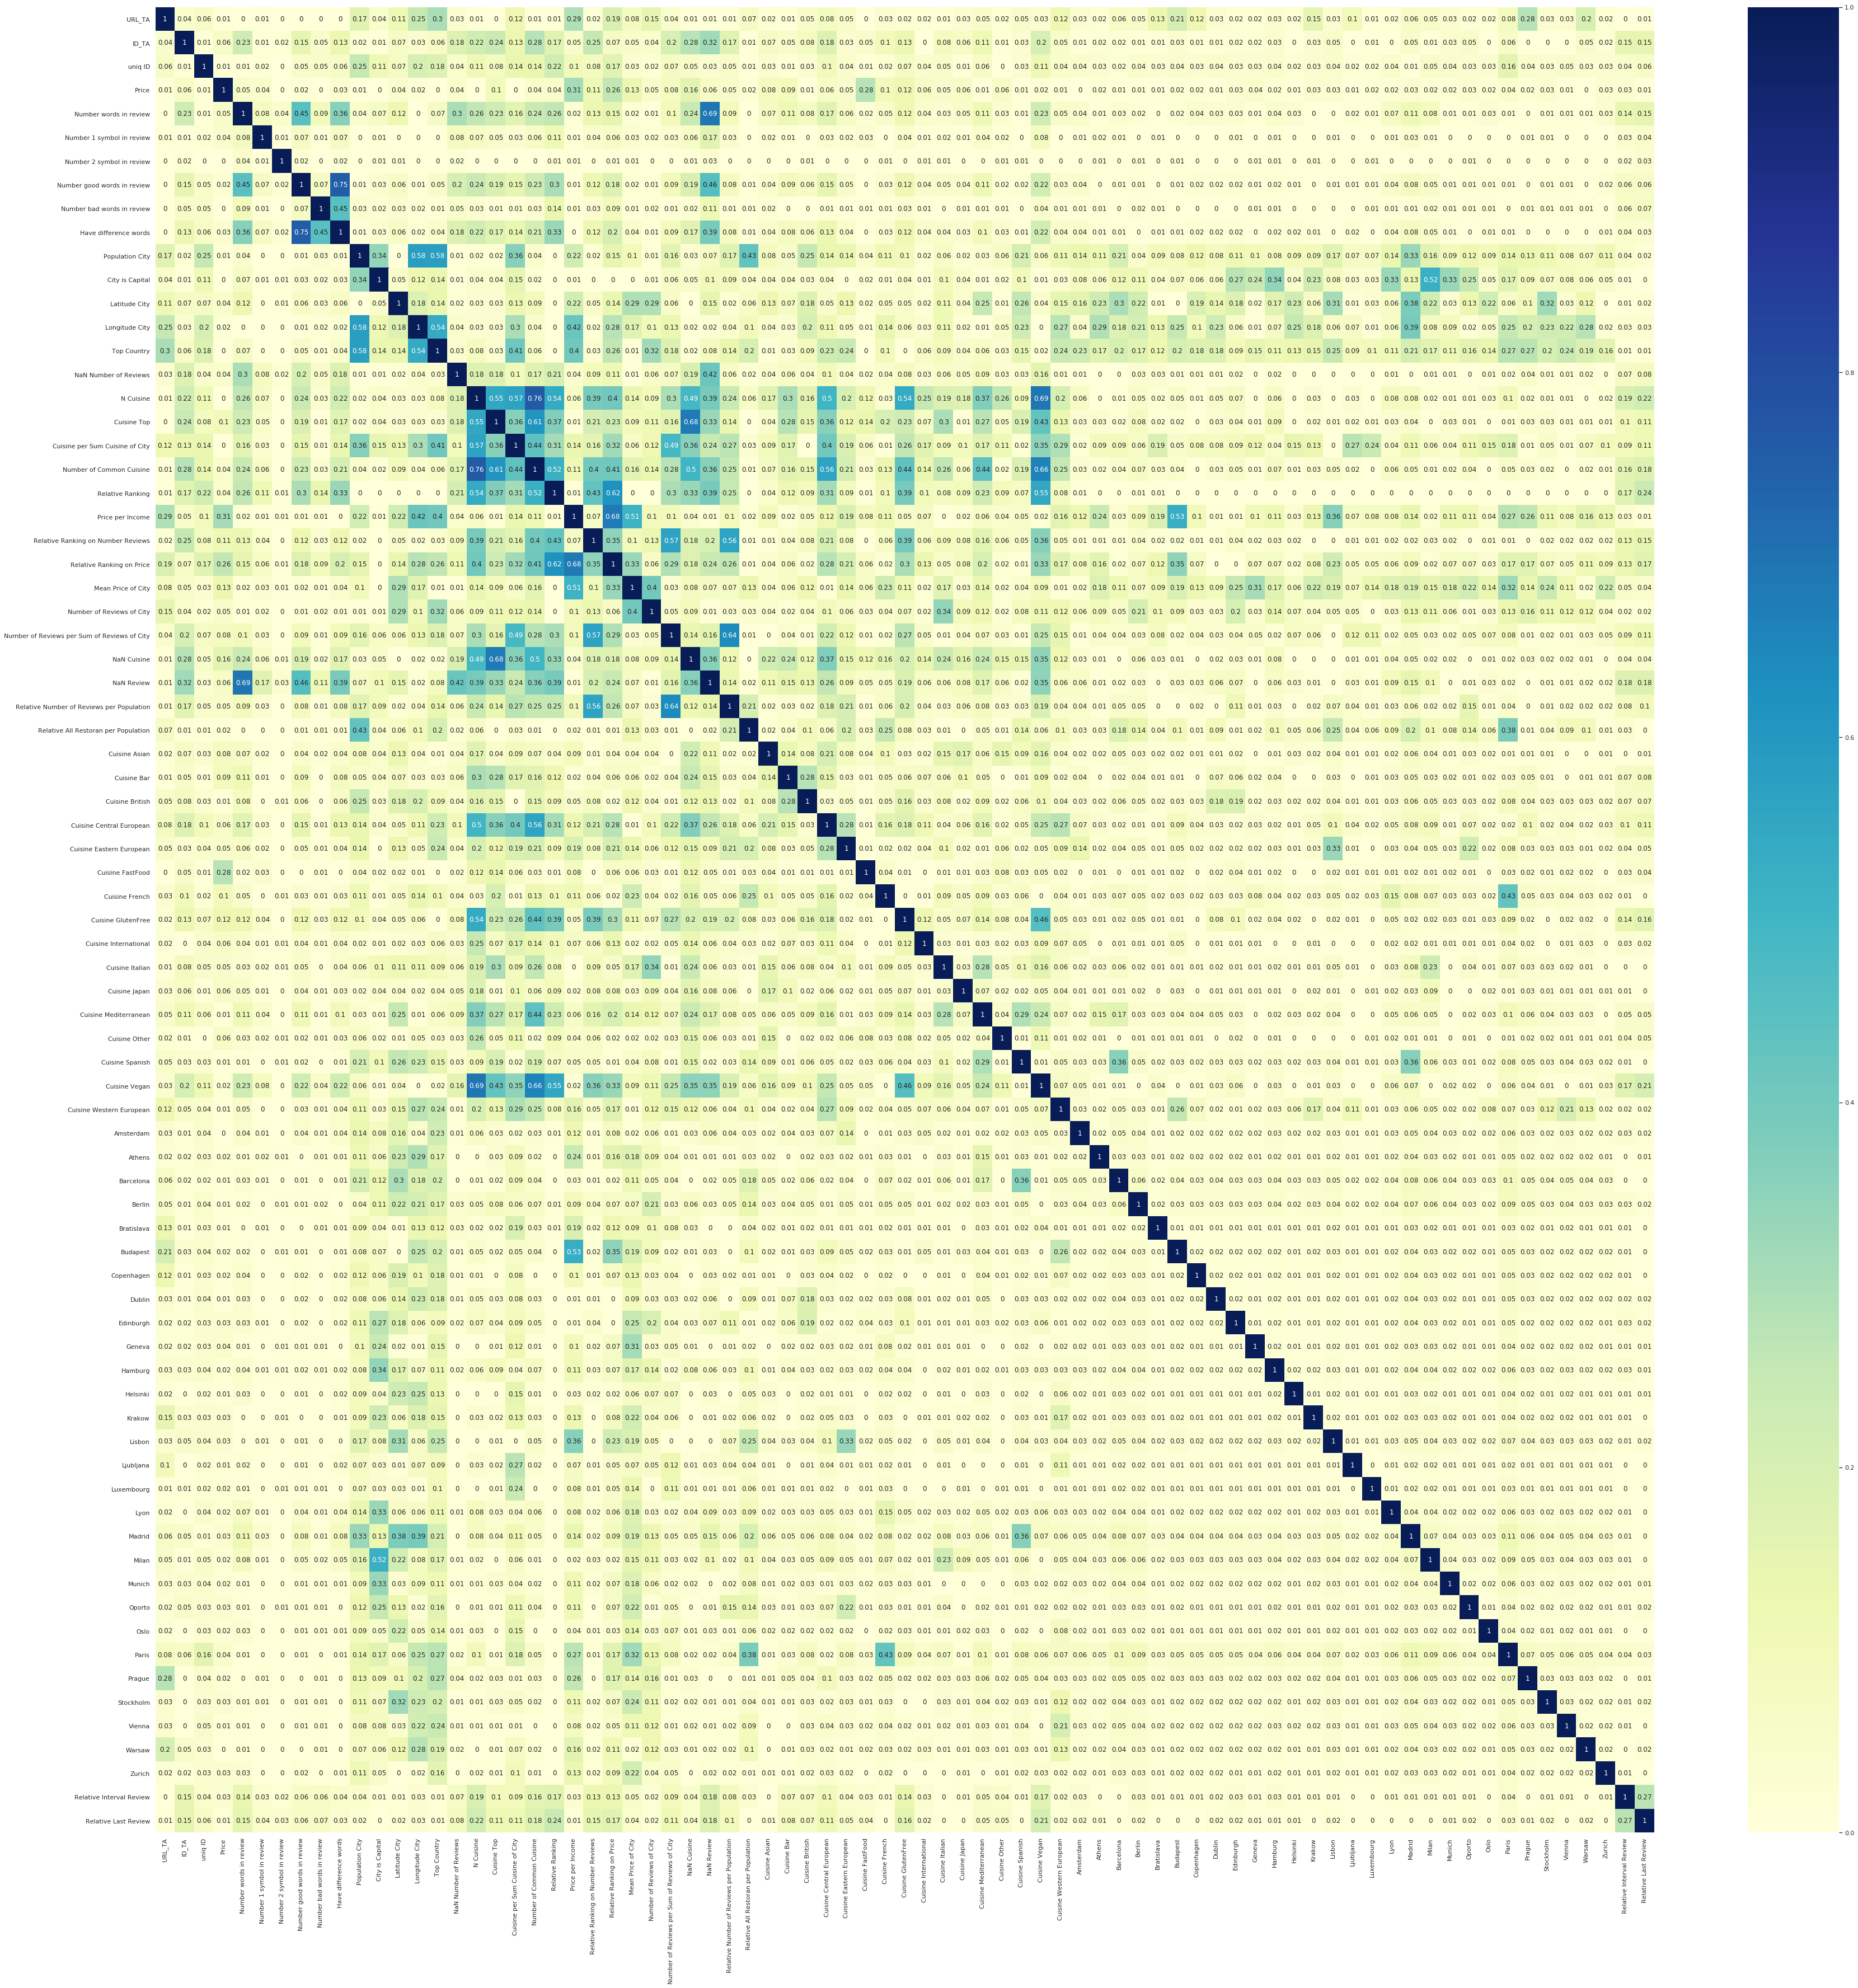

In [99]:
#Тепловая карта для матрицы корреляций
table_corr = abs(df.drop(['Rating','Kaggle'],axis=1).corr().round(2))
plt.rcParams['figure.figsize'] = (60,60)
sns.heatmap(table_corr, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

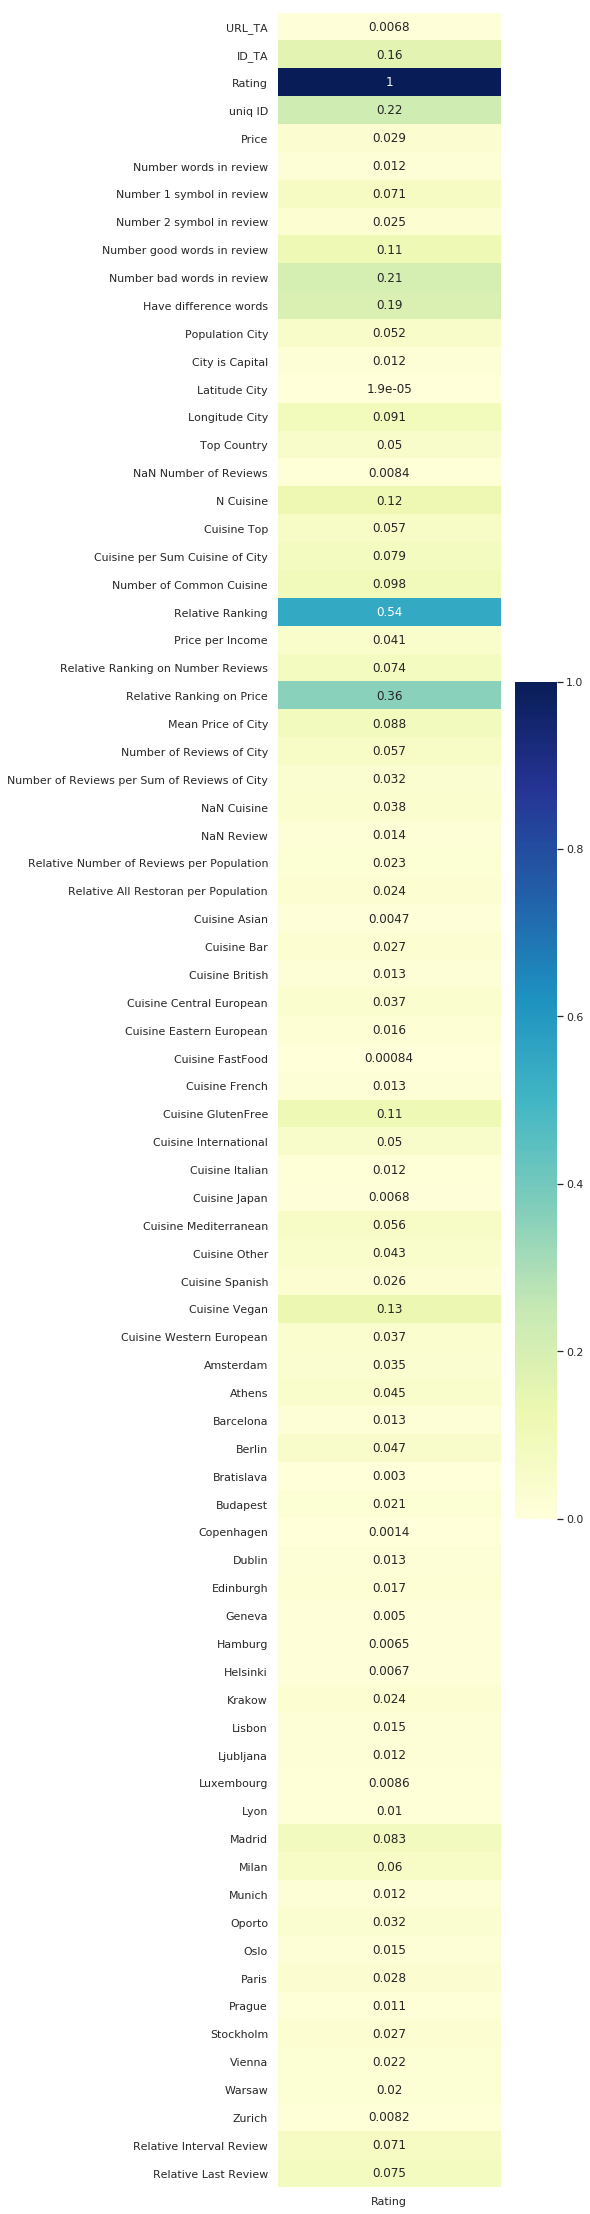

In [100]:
#Матрица корреляций для признака Rating на обучающей выборке
table_corr_rating = abs(df[df['Kaggle'] == 0].corr()['Rating'].dropna().to_frame())
plt.rcParams['figure.figsize'] = (5,40)
sns.heatmap(table_corr_rating, vmin=0, vmax=1, cmap="YlGnBu",annot=True)

***Наиболее коррелирующие параметры с Rating: Ranking, Relative Ranking, Relative Ranking on Price, uniq ID, Number bad words in reviews, Have difference words. Осмотрим данные признаки.***

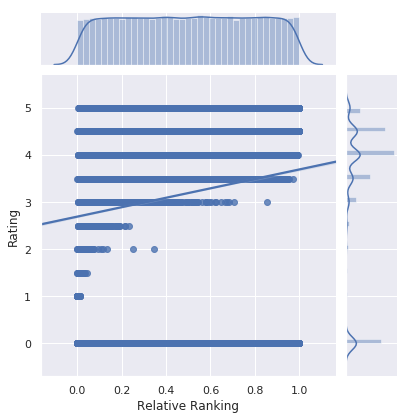

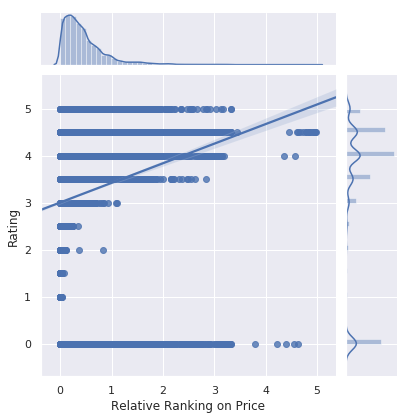

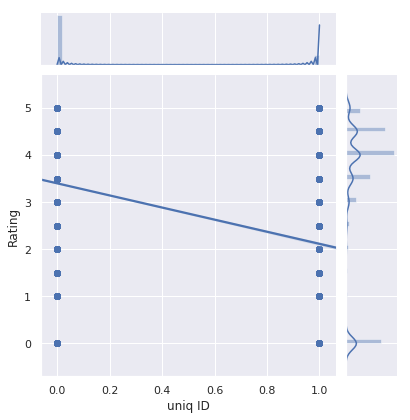

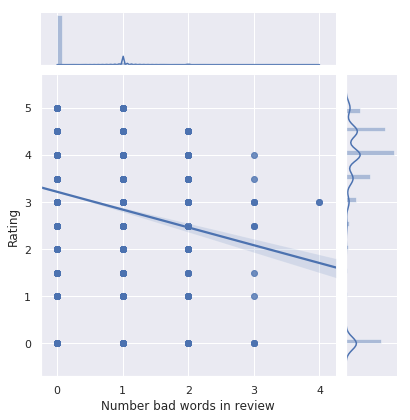

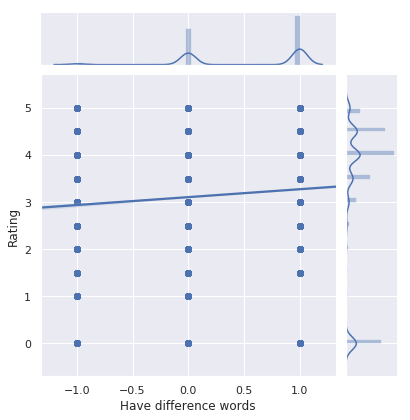

In [101]:
cols_sub = ['Relative Ranking', 'Relative Ranking on Price', 'uniq ID', 'Number bad words in review','Have difference words']
for col in cols_sub:
    plt.rcParams['figure.figsize'] = (15,10)
    sns.jointplot(data=df,x=col,y='Rating', kind="reg")

***Анализ показал, что корреляция по знаку установлена верно, но стоит доработать часть признаков: определение тональности отзыва, uniq_ID.***

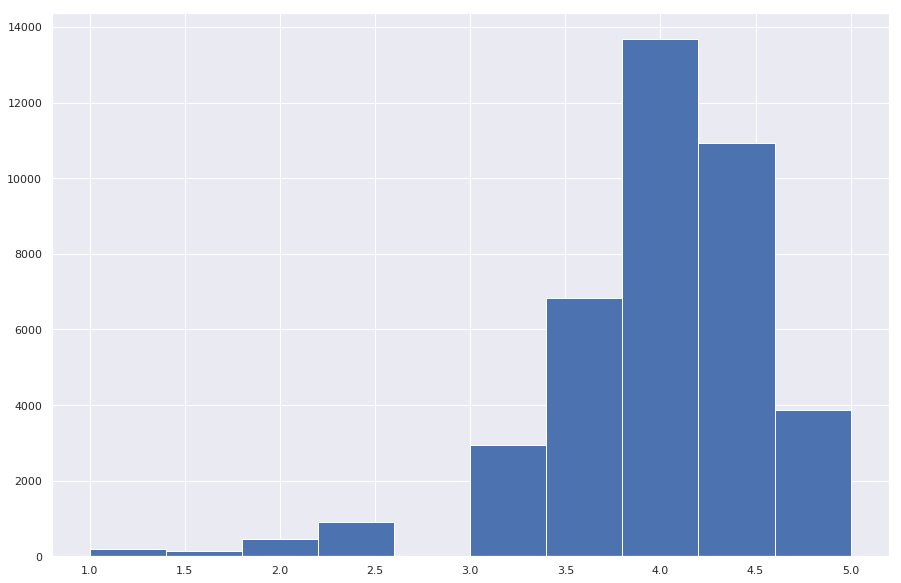

In [102]:
#Распределение параметра Rating
plt.rcParams['figure.figsize'] = (15,10)
df[df['Kaggle'] == 0]['Rating'].hist()

***Все значения кратны 0.5. Распределение похоже на нормальное со смещение влево. Конечный результат должен иметь такую же форму.***

***Еще раз посмотрим на параметр Relative Ranking on Price и Relative Ranking.***

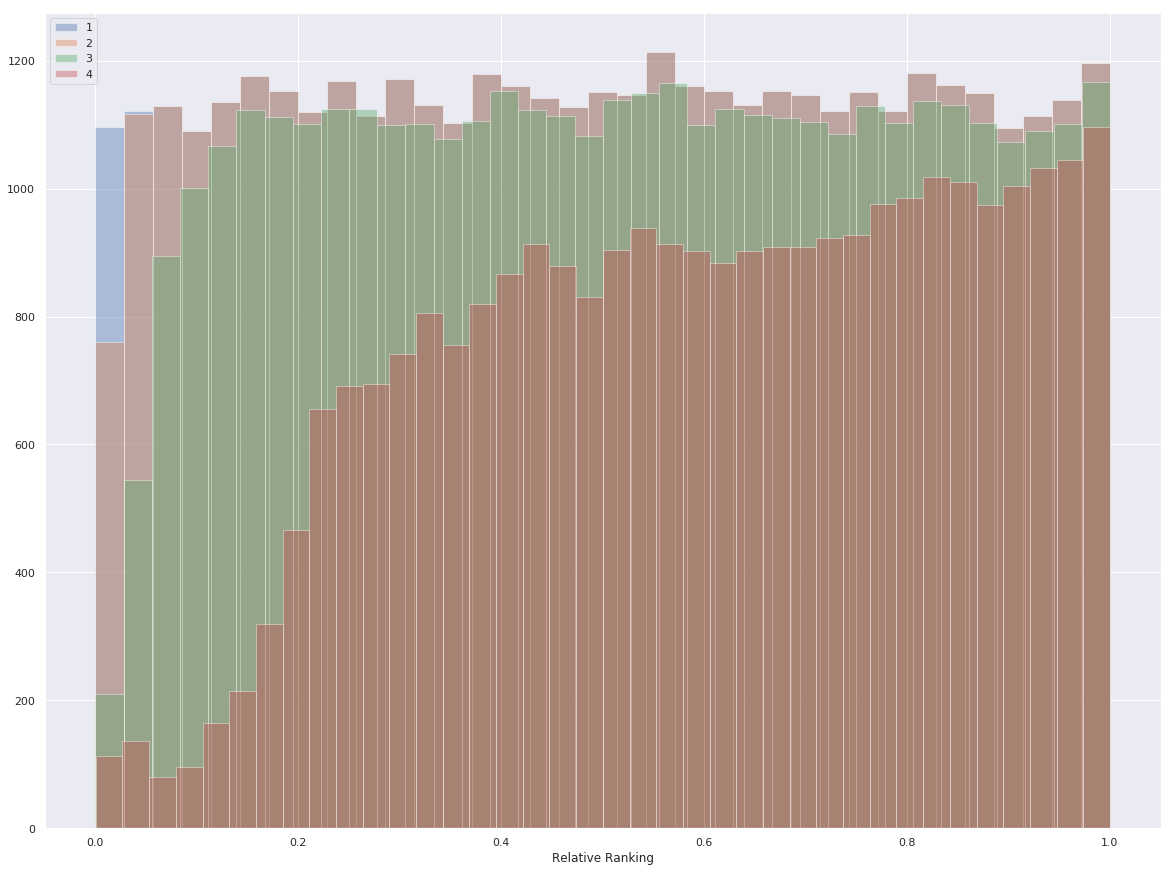

In [103]:
#Выделим данные
df_sub = df[df['Kaggle'] == 0][['Relative Ranking','Rating']]
mas = [1,2,3,4]
fig = plt.figure(figsize=(20,15))
for x in mas:
    df_sub_new = df_sub[df_sub['Rating'] >= x]['Relative Ranking']
    ax=sns.distplot(df_sub_new, kde=False,label='1')
ax.legend(labels=[str(x) for x in mas])

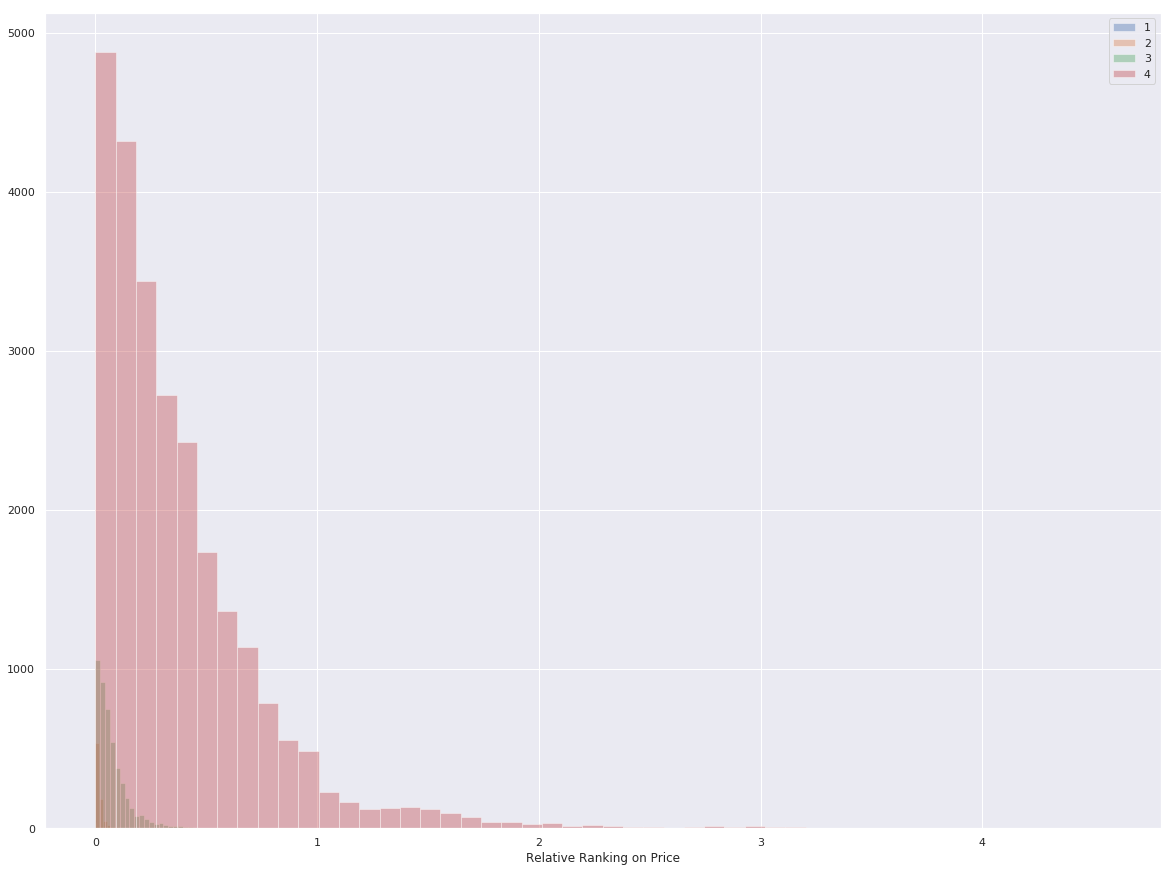

In [104]:
#Выделим данные
df_sub = df[df['Kaggle'] == 0][['Relative Ranking on Price','Rating']]
mas = [1,2,3,4]
fig = plt.figure(figsize=(20,15))
for x in mas:
    df_sub_new = df_sub[df_sub['Rating'] <= x]['Relative Ranking on Price']
    ax=sns.distplot(df_sub_new, kde=False,label='1')
ax.legend(labels=[str(x) for x in mas])

***Для Relative Ranking заметна закономерность - с ростом Rating уменьшается область слева, что логично. Но все равно присутствуют рестораны, занимающие в рейтенге по городу низкое место, но при этом имеющие высокий рейтинг.***

***Для Relative Ranking on Price, видно, что более хорошие рестроны с высоким рейтингом имеют значительно более высокое значение данного параметра, что удобно для модели.***

# 6. Машинное обучение

## 6.1) Предобработка

***Проверим, правильно ли мы подготовили датасэт для модели.***

In [105]:
#Осмотр данных
df.isna().sum().sum()

0

In [106]:
#Осмотр данных
df.dtypes[df.dtypes == 'object']

City                      object
Country                   object
Cuisine                   object
Common Cuisine of City    object
dtype: object

In [107]:
#Удаляем номинативные признаки
df.drop(['City','Country','Cuisine','Common Cuisine of City'], axis=1, inplace=True)

***Удалили все номинативные параметры. Выделяем обучающую и тестовую выборку.***

In [108]:
#Выделяем train
df_sub = df[df['Kaggle'] == 0]

In [109]:
X = df_sub.drop(['Rating','Kaggle'], axis=1)
y = df_sub['Rating']
#Разбиение на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=RANDOM_SEED)

## 6.2) Обучение

***Параметры модели не меняем относительно того, что было в BaseLine решении по условию задания.***

In [110]:
#Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
# Обучаем модель
model.fit(X_train, y_train)
#Предсказываем
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


***Обратим внимание на то, как выглядит параметр Rating. Дело в том, что все значения в нем кратны 0.5. Этот вывод поможет увеличить точность решения.***

In [111]:
#Список уникальных значений в столбце Rating
df['Rating'].unique()

array([0. , 3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

In [112]:
mas = np.arange(0,5.5,0.5)
#Функция для округления
def round_sub(x):
    return mas[abs(x - mas).argmin()]

In [113]:
#Округление полученного решения
y_pred_round = np.array(list(map(round_sub,y_pred)))

In [114]:
#Выводим метрику
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE round:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.19647749999999997
MAE round: 0.164


***Как видно, при округлении качество модели значительно улучшается.***

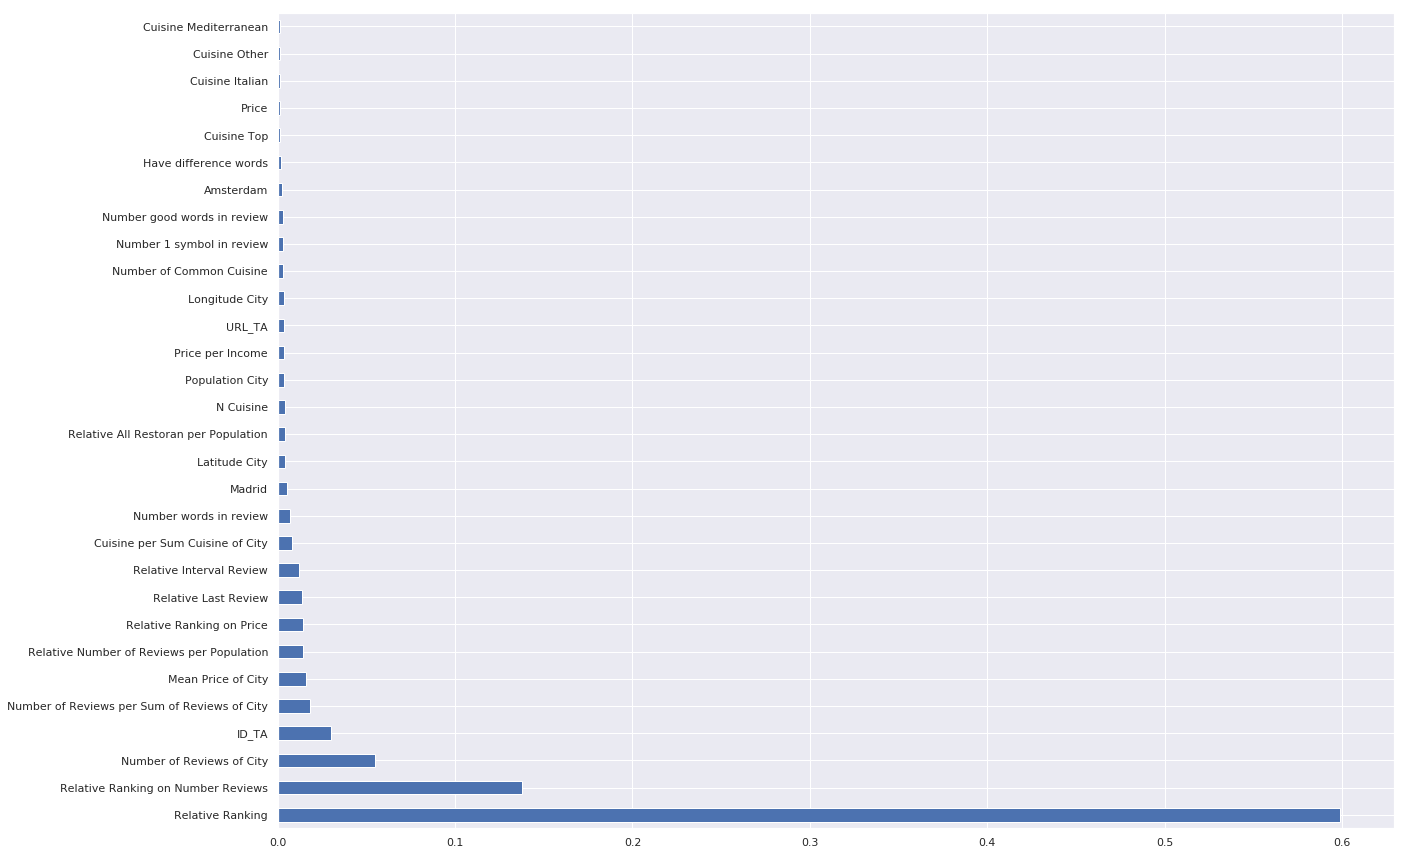

In [115]:
#Наиболее важные признаки
plt.rcParams['figure.figsize'] = (20,15)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

***Для отправки *.csv файла на Kaggle используем тестовую выборку и используем обученную ранее модель для предсказания.***

In [116]:
#Проверка модели на test данных
test_data = df[df['Kaggle'] == 1].drop(columns=['Rating','Kaggle'])
#Проверка
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


***Читаем, округляем, сохраняем и выводим.***

In [117]:
#Чтение файла с результатами
sample_submission = pd.read_csv(DATA_DIR + '/sample_submission.csv')
#Округление результатов
predict_submission_round = np.array(list(map(round_sub,predict_submission)))
#Сохранение результатов
sample_submission['Rating'] = predict_submission_round
#Вывод в файл
sample_submission.to_csv('submission.csv', index=False)
#Осмотр данных
sample_submission.head(10)

Restaurant_id  Rating
0          id_0     3.0
1          id_1     4.0
2          id_2     4.5
3          id_3     4.5
4          id_4     4.5
5          id_5     4.5
6          id_6     2.0
7          id_7     3.5
8          id_8     4.0
9          id_9     4.5

***Копия проекта на Git-Hub: https://github.com/MirtosSergey/SF_project/tree/master.***